# DogFaceNet version 11: Dev version number on LFW dataset


### Imports and constants

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

import os
import pickle
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import tensorflow.keras.backend as K
from triplets_processing import *
import shutil
import gc

In [2]:
PATH = '../../../data/lfw_center/'
#PATH = 'D:/PROGRAMMATION/Dataset/lfw/lfw_center/'
PATH_SAVE = '../output/history/'
PATH_MODEL = '../output/model/'
SIZE = (151,151,3)
VALID_SPLIT = 0.1
TEST_SPLIT = 0.1

### Data pre-processing
- Load image and labels
- Training set, validation set (close-set) and testing (open-set)

In [ ]:
filenames = np.empty(0)
labels = np.empty(0)
idx = 0
for root,dirs,files in os.walk(PATH):
    if len(files)>1:
        for i in range(len(files)):
            files[i] = root + '/' + files[i]
        filenames = np.append(filenames,files)
        labels = np.append(labels,np.ones(len(files))*idx)
        idx += 1
print(len(labels))
h,w,c = SIZE
images = np.empty((len(filenames),h,w,c))
for i,f in enumerate(filenames):
    images[i] = sk.io.imread(f)

In [ ]:
# Normalization
images /= 255.0


In [ ]:
# Resize all the images
filenames = np.empty(0)
labels = np.empty(0)
idx = 0
for root,dirs,files in os.walk(PATH):
    if len(files)>1:
        for i in range(len(files)):
            files[i] = root + '/' + files[i]
            sk.io.imsave(files[i],sk.transform.resize(sk.io.imread(files[i]),SIZE,anti_aliasing=True))

In [3]:
# Without imread

filenames = np.empty(0)
labels = np.empty(0)
idx = 0
for root,dirs,files in os.walk(PATH):
    if len(files)>1:
        for i in range(len(files)):
            files[i] = root + '/' + files[i]
        filenames = np.append(filenames,files)
        labels = np.append(labels,np.ones(len(files))*idx)
        idx += 1
    if len(files) == 1:
        #print(root)
        shutil.rmtree(root)
print(len(labels))
filenames

9164


array(['D:/PROGRAMMATION/Dataset/lfw/lfw_center/Aaron_Peirsol/Aaron_Peirsol_0001.jpg',
       'D:/PROGRAMMATION/Dataset/lfw/lfw_center/Aaron_Peirsol/Aaron_Peirsol_0002.jpg',
       'D:/PROGRAMMATION/Dataset/lfw/lfw_center/Aaron_Peirsol/Aaron_Peirsol_0003.jpg',
       ...,
       'D:/PROGRAMMATION/Dataset/lfw/lfw_center/Zoran_Djindjic/Zoran_Djindjic_0002.jpg',
       'D:/PROGRAMMATION/Dataset/lfw/lfw_center/Zoran_Djindjic/Zoran_Djindjic_0003.jpg',
       'D:/PROGRAMMATION/Dataset/lfw/lfw_center/Zoran_Djindjic/Zoran_Djindjic_0004.jpg'],
      dtype='<U112')

In [4]:
nbof_classes = len(np.unique(labels))
print(nbof_classes)

1680


In [ ]:
# Center all the faces
for f in filenames:
    img = sk.io.imread(f)
    img_c = img[50:201,50:201,:]
    sk.io.imsave(f,img_c)

In [ ]:
img_c.shape

### Data augmentation

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=8,
    zoom_range=0.1,
    fill_mode='nearest',
    channel_shift_range = 0.1
)

In [ ]:

def apply_transform(images, datagen):
    """
    Apply a data preprocessing transformation to n images
    Args:
        -images
        -ImageDataGenerator
    Return:
        -images of the same shape of the inputs but transformed
    """
    for x in datagen.flow(images, batch_size=len(images), shuffle=False):
        return x

Open-set: test set

In [ ]:
n = 3
cumul = np.empty(labels.shape)
cumul[0] = 1
crt_label = labels[0]
to_keep = []
for i in range(1,len(labels)):
    if labels[i] == labels[i-1]:
        cumul[i] = cumul[i-1] + 1
    else:
        cumul[i] = 1
        if cumul[i-1] >= n:
            to_keep += [labels[i-1]]
bool_keep = np.zeros(labels.shape, dtype=bool)
for i in range(len(to_keep)):
    bool_keep = np.logical_or(bool_keep,np.equal(to_keep[i],labels))
print("Ratio of kept classes: " + str(len(to_keep)/nbof_classes))
print("Ratio of kept images: " + str(len(labels[bool_keep])/len(labels)))
filenames_train = filenames[bool_keep]
labels_train = labels[bool_keep]

keep_test = np.logical_not(bool_keep)
filenames_test = filenames[keep_test]
labels_test = labels[keep_test]

In [5]:
nbof_test = int(TEST_SPLIT*nbof_classes)

keep_test = np.less(labels,nbof_test)
keep_train = np.logical_not(keep_test)

filenames_test = filenames[keep_test]
labels_test = labels[keep_test]

filenames_train = filenames[keep_train]
labels_train = labels[keep_train]

print("Number of training data: " + str(len(filenames_train)))
print("Number of training classes: " + str(nbof_classes-nbof_test))
print("Number of testing data: " + str(len(filenames_test)))
print("Number of testing classes: " + str(nbof_test))

Number of training data: 8241
Number of training classes: 1512
Number of testing data: 923
Number of testing classes: 168


In [ ]:
nbof_test = int(TEST_SPLIT*nbof_classes)

keep_test = np.less(labels,nbof_test)
keep_train = np.logical_not(keep_test)

images_test = images[keep_test]
labels_test = labels[keep_test]

images_train = images[keep_train]
labels_train = labels[keep_train]

In [ ]:
del images
del labels
gc.collect()

In [6]:
def define_triplets_batch(filenames,labels,nbof_triplet = 21 * 3):
    
    triplet_train = []
    y_triplet = np.empty(nbof_triplet)
    classes = np.unique(labels)
    for i in range(0,nbof_triplet,3):
        # Pick a class and chose two pictures from this class
        classAP = classes[np.random.randint(len(classes))]
        keep = np.equal(labels,classAP)
        keep_classAP = filenames[keep]
        keep_classAP_idx = labels[keep]
        idx_image1 = np.random.randint(len(keep_classAP))
        idx_image2 = np.random.randint(len(keep_classAP))
        while idx_image1 == idx_image2:
            idx_image2 = np.random.randint(len(keep_classAP))

        triplet_train += [keep_classAP[idx_image1]]
        triplet_train += [keep_classAP[idx_image2]]
        y_triplet[i] = keep_classAP_idx[idx_image1]
        y_triplet[i+1] = keep_classAP_idx[idx_image2]
        # Pick a class for the negative picture
        classN = classes[np.random.randint(len(classes))]
        while classN==classAP:
            classN = classes[np.random.randint(len(classes))]
        keep = np.equal(labels,classN)
        keep_classN = filenames[keep]
        keep_classN_idx = labels[keep]
        idx_image3 = np.random.randint(len(keep_classN))
        triplet_train += [keep_classN[idx_image3]]
        y_triplet[i+2] = keep_classN_idx[idx_image3]
        
    return triplet_train, y_triplet

In [21]:
def define_hard_triplets_batch(filenames,labels,predict,nbof_triplet=21*3, use_neg=True, use_pos=True):
    """
    Generates hard triplet for offline selection. It will consider the whole dataset.
    
    Args:
        -images: images from which the triplets will be created
        -labels: labels of the images
        -predict: predicted embeddings for the images by the trained model
        -alpha: threshold of the triplet loss
    Returns:
        -triplet
        -y_triplet: labels of the triplets
    """
    # Check if we have the right number of triplets
    assert nbof_triplet%3 == 0
    
    _,idx_classes = np.unique(labels,return_index=True)
    classes = labels[np.sort(idx_classes)]
    
    triplets = []
    y_triplets = np.empty(nbof_triplet)
    
    idx_triplets = 0
    idx_images = 0
    
    for i in range(0,nbof_triplet,3):
        # Chooses the first class randomly
        keep = np.equal(labels,classes[np.random.randint(len(classes))])
        keep_filenames = filenames[keep]
        keep_labels = labels[keep]
        
        # Chooses the first image among this class randomly
        idx_image1 = np.random.randint(len(keep_labels))
        
        
        # Computes the distance between the chosen image and the rest of the class
        if use_pos:
            dist_class = np.sum(np.square(predict[keep]-predict[keep][idx_image1]),axis=-1)

            idx_image2 = np.argmax(dist_class)
        else:
            idx_image2 = np.random.randint(len(keep_labels))
            i = 0
            while idx_image1==idx_image2:
                idx_image2 = np.random.randint(len(keep_labels))
                # Just to prevent endless loop:
                i += 1
                if i == 1000:
                    print("[Error: define_hard_triplets_batch] Endless loop.")
                    break
        
        triplets += [keep_filenames[idx_image1]]
        y_triplets[i] = keep_labels[idx_image1]
        triplets += [keep_filenames[idx_image2]]
        y_triplets[i+1] = keep_labels[idx_image2]
        
        
        # Computes the distance between the chosen image and the rest of the other classes
        not_keep = np.logical_not(keep)
        
        if use_neg:
            dist_other = np.sum(np.square(predict[not_keep]-predict[keep][idx_image1]),axis=-1)
            idx_image3 = np.argmin(dist_other) 
        else:
            idx_image3 = np.random.randint(len(filenames[not_keep]))
            
        triplets += [filenames[not_keep][idx_image3]]
        y_triplets[i+2] = labels[not_keep][idx_image3]

    #return triplets, y_triplets
    return np.array(triplets), y_triplets

In [8]:
def load_images(filenames):
    h,w,c = SIZE
    #print(filenames)
    images = np.empty((len(filenames),h,w,c))
    for i,f in enumerate(filenames):
        #print(f)
        images[i] = sk.io.imread(f)/255.0
    return images

In [9]:
def image_generator(filenames, labels, batch_size=63, use_aug=True, datagen=datagen):
    while True:
        f_triplet, y_triplet = define_triplets_batch(filenames, labels, batch_size)
        i_triplet = load_images(f_triplet)
        if use_aug:
            i_triplet = apply_transform(i_triplet, datagen)
        yield (i_triplet, y_triplet)

In [10]:
def hard_image_generator(filenames, labels, predict, batch_size=63, use_neg=True, use_pos=True, use_aug=True, datagen=datagen):
    while True:
        f_triplet, y_triplet = define_hard_triplets_batch(filenames, labels, predict, batch_size, use_neg=use_neg, use_pos=use_pos)
        i_triplet = load_images(f_triplet)
#         for f in f_triplet:
#             print(f)
        if use_aug:
            i_triplet = apply_transform(i_triplet, datagen)
        yield (i_triplet, y_triplet)

In [11]:
def predict_generator(filenames, batch_size=32):
    for i in range(0,len(filenames),batch_size):
        images_batch = load_images(filenames[i:i+batch_size])
        yield images_batch

In [12]:
def online_hard_image_generator(
    filenames,
    labels,
    model,
    batch_size=63,
    nbof_subclasses=10,
    use_neg=True,
    use_pos=True,
    use_aug=True,
    datagen=datagen):
    """
    Generator to select online hard triplets for training.
    
    Arguments:
        -filenames
        -labels
    """
    while True:
        # Select a certain amount of subclasses
        classes = np.unique(labels)
        subclasses = np.random.choice(classes,size=nbof_subclasses,replace=False)
        
        keep_classes = np.equal(labels,subclasses[0])
        for i in range(1,len(subclasses)):
            keep_classes = np.logical_or(keep_classes,np.equal(labels,subclasses[i]))
        subfilenames = filenames[keep_classes]
        sublabels = labels[keep_classes]
        predict = model.predict_generator(predict_generator(subfilenames, 32),
                                          steps=np.ceil(len(subfilenames)/32))
        
        f_triplet, y_triplet = define_hard_triplets_batch(subfilenames, sublabels, predict, batch_size, use_neg=use_neg, use_pos=use_pos)
        i_triplet = load_images(f_triplet)
        if use_aug:
            i_triplet = apply_transform(i_triplet, datagen)
        yield (i_triplet, y_triplet)

In [31]:
def online_adaptive_hard_image_generator(
    filenames,
    labels,
    model,
    batch_size=63,
    nbof_subclasses=10,
    use_neg=True,
    use_pos=True,
    use_aug=True,
    datagen=datagen):
    """
    Generator to select online hard triplets for training.
    
    Include an adaptive control on the number of hard triplets included during the training.
    
    Arguments:
        -filenames
        -labels
    """
    batch_loss = batch_size
    hard_triplet_ratio = 0
    nbof_hard_triplets = 0
    while True:
        # Select a certain amount of subclasses
        classes = np.unique(labels)
        subclasses = np.random.choice(classes,size=nbof_subclasses,replace=False)
        
        keep_classes = np.equal(labels,subclasses[0])
        for i in range(1,len(subclasses)):
            keep_classes = np.logical_or(keep_classes,np.equal(labels,subclasses[i]))
        subfilenames = filenames[keep_classes]
        sublabels = labels[keep_classes]
        predict = model.predict_generator(predict_generator(subfilenames, 32),
                                          steps=np.ceil(len(subfilenames)/32))
        
        
        
        
        
        f_triplet_hard, y_triplet_hard = define_hard_triplets_batch(subfilenames, sublabels, predict, nbof_hard_triplets*3, use_neg=True, use_pos=True)
        f_triplet_soft, y_triplet_soft = define_hard_triplets_batch(subfilenames, sublabels, predict, batch_size-nbof_hard_triplets*3, use_neg=False, use_pos=False)
#         print(f_triplet_soft)
#         print("shape hard: " + str(f_triplet_hard.shape))
#         print("shape soft: " + str(f_triplet_soft.shape))
        f_triplet = np.append(f_triplet_hard,f_triplet_soft)
        y_triplet = np.append(y_triplet_hard,y_triplet_soft)
        
        # Proportion of hard triplets in the generated batch
        batch_loss = triplet_numpy(f_triplet, y_triplet)
#         print(batch_loss)
        hard_triplet_ratio = np.exp(-batch_loss * 10 / batch_size)
#         print(hard_triplet_ratio)
        nbof_hard_triplets = int(batch_size//3 * hard_triplet_ratio)
#         print(nbof_hard_triplets)
        
        i_triplet = load_images(f_triplet)
        if use_aug:
            i_triplet = apply_transform(i_triplet, datagen)
        yield (i_triplet, y_triplet)

In [ ]:
# Test normal triplets
for a,y in image_generator(filenames_train,labels_train,9):
    for i in range(3):
        for j in range(3):
            plt.subplot(3,3,3*i+j+1)
            plt.imshow(a[i*3+j])
    break

In [ ]:
# Test load_images
fs = filenames_train[np.equal(labels_train,745)]
print(fs)
ise = load_images(fs)
for i in range(len(ise)):
    plt.subplot(len(ise),5,i+1)
    plt.imshow(ise[i])

In [ ]:
# Test hard triplets
batch_predict = 32

#predict_train = np.random.random((len(labels_train),1))
# predict_train = model.predict_generator(predict_generator(filenames_train, batch_predict),
#                                   steps=np.ceil(len(filenames_train)/batch_predict))
disp = 10
plt.figure(figsize=(7,disp*2.2))
for a,y in hard_image_generator(filenames_train,labels_train, predict_train, disp*3, use_aug=False):
    for i in range(10):
        for j in range(3):
            plt.subplot(10,3,3*i+j+1)
            plt.imshow(a[i*3+j])
    
    print(y)
    break

In [23]:
# Test online hard triplets

disp = 10
plt.figure(figsize=(7,disp*2.2))
for a,y in online_hard_image_generator(filenames_train,labels_train, model, disp*3, use_neg=False):
    for i in range(disp):
        for j in range(3):
            plt.subplot(10,3,3*i+j+1)
            plt.imshow(a[i*3+j])
    print(y)
    break

NameError: name 'online_hard_image_generator' is not defined

<Figure size 504x1584 with 0 Axes>

[ 307.  307.  782.  863. 1097.  639.  924.  924.  586.  586.  924. 1022.
 1097. 1097. 1097. 1097. 1097. 1097. 1155. 1155. 1155. 1268. 1268. 1441.
 1441. 1655. 1655. 1655. 1655. 1655.]


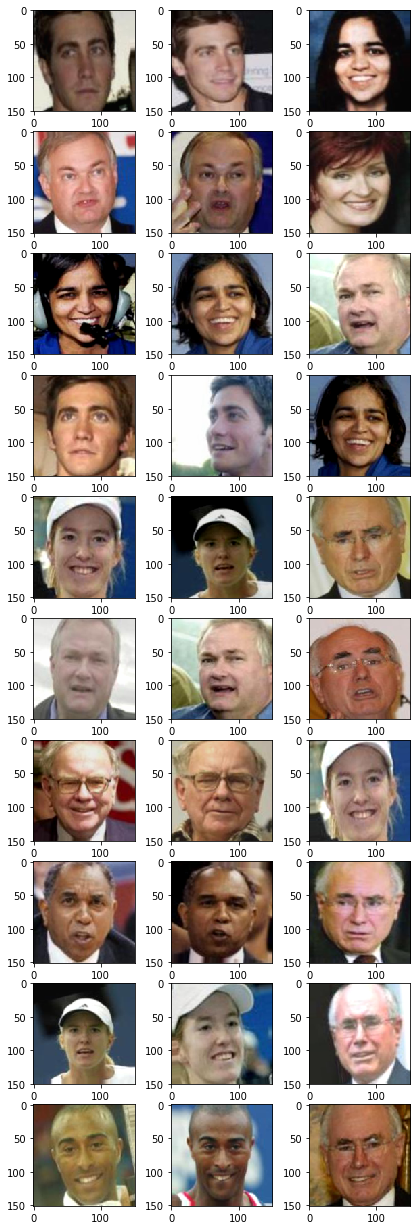

In [32]:
# Test online hard triplets

disp = 10
plt.figure(figsize=(7,disp*2.2))
for a,y in online_adaptive_hard_image_generator(filenames_train,labels_train, model, disp*3):
    for i in range(disp):
        for j in range(3):
            plt.subplot(10,3,3*i+j+1)
            plt.imshow(a[i*3+j])
    print(y)
    break

In [ ]:
# Test predict_generator
batch_predict = 32
predict_train = model.predict_generator(predict_generator(filenames_train, batch_predict),
                                  steps=np.ceil(len(filenames_train)/batch_predict))
print(len(predict_train))

Triplet test definition

In [ ]:
h,w,c = SIZE
images_test = np.empty((len(filenames_test),h,w,c))
for i,f in enumerate(filenames_test):
    images_test[i] = sk.io.imread(f)

In [ ]:
#triplet_train, y_triplet_train = define_triplets(images_train,labels_train)
triplet_test, y_triplet_test = define_triplets(images_test,labels_test,1000*3)

### Loss definition

In [13]:
alpha = 0.3
def triplet_numpy(y_true,y_pred):
    
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = np.sum(np.square(a-p),-1)
    an = np.sum(np.square(a-n),-1)

    return np.sum(np.maximum(ap - an + alpha,0))

In [14]:
alpha = 0.3
def triplet(y_true,y_pred):
    
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(K.square(a-p),-1)
    an = K.sum(K.square(a-n),-1)

    return K.sum(tf.nn.relu(ap - an + alpha))

### Metric definition

In [15]:
def triplet_acc(y_true,y_pred):
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(K.square(a-p),-1)
    an = K.sum(K.square(a-n),-1)
    
    return K.less(ap+alpha,an)

### Model definition

In [ ]:
# inception net small

emb_size = 64

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Add, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

inputs = Input(shape=SIZE)

x = Conv2D(64, (7, 7), use_bias=False, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)

for layer in [16,32,64,128,512]:

    x = Conv2D(layer, (3, 3), strides=(2,2), use_bias=False, activation='relu', padding='same')(x)
    r = BatchNormalization()(x)
    r = Dropout(0.25)(r)
    
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = BatchNormalization()(x)
    r = Add()([r,x])
    r = Dropout(0.25)(r)
    
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = BatchNormalization()(x)
    x = Add()([r,x])
    x = Dropout(0.25)(x)
    

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(emb_size, use_bias=False)(x)
outputs = Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1))(x)

model = tf.keras.Model(inputs,outputs)

model.compile(loss=triplet,
              optimizer='adam',
              metrics=[triplet_acc])
model.summary()

In [ ]:
# dogfacenet_v25: Resnet like
emb_size = 64

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Add, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

inputs = Input(shape=SIZE)

x = Conv2D(64, (7, 7), strides=(2,2), use_bias=False, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((3,3),strides=(2,2))(x)

for layer in [128,256]:

    x = Conv2D(layer, (3, 3), strides=(2,2), use_bias=False, padding='same')(x)
    r = BatchNormalization()(x)
    r = Activation('relu')(r)
    
    x = Conv2D(layer, (3, 3), use_bias=False, padding='same')(r)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    r = Add()([r,x])
    
    x = Conv2D(layer, (3, 3), use_bias=False, padding='same')(r)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Add()([r,x])

    

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dropout(0.6)(x)
x = Dense(emb_size, use_bias=False)(x)
outputs = Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1))(x)

model = tf.keras.Model(inputs,outputs)

model.compile(loss=triplet,
              optimizer='adam',
              metrics=[triplet_acc])
model.summary()

In [ ]:
# dogfacenet_v11: VGG like
emb_size = 16

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(104, 104, 3)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(1024, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(emb_size))
model.add(Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1)))

model.compile(loss=triplet,
              optimizer='adam',
              metrics=[triplet_acc])
model.summary()

In [15]:
# dogfacenet_v12: Resnet like
emb_size = 64

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Add, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

inputs = Input(shape=SIZE)

x = Conv2D(16, (7, 7), use_bias=False, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)

for layer in [16,32,64,128,512]:

    x = Conv2D(layer, (3, 3), strides=(2,2), use_bias=False, activation='relu', padding='same')(x)
    r = BatchNormalization()(x)
    r = Dropout(0.25)(r)
    
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = BatchNormalization()(x)
    r = Add()([r,x])
    r = Dropout(0.25)(r)
    
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = BatchNormalization()(x)
    x = Add()([r,x])
    x = Dropout(0.25)(x)
    

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(emb_size, use_bias=False)(x)
outputs = Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1))(x)

model = tf.keras.Model(inputs,outputs)

model.compile(loss=triplet,
              optimizer='adam',
              metrics=[triplet_acc])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 151, 151, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 151, 151, 16) 2352        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 151, 151, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 76, 76, 16)   2304        batch_normalization[0][0]        
__________________________________________________________________________________________________
batch_norm

In [ ]:
# dogfacenet_v12: Resnet like
emb_size = 64

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Add, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

inputs = Input(shape=SIZE)

x = Conv2D(16, (7, 7), use_bias=False, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)

for layer in [16,32,64,128,512]:

    x = Conv2D(layer, (3, 3), strides=(2,2), use_bias=False, activation='relu', padding='same')(x)
    r = BatchNormalization()(x)
#     r = Dropout(0.25)(r)
    
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = BatchNormalization()(x)
    r = Add()([r,x])
#     r = Dropout(0.25)(r)
    
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = BatchNormalization()(x)
    x = Add()([r,x])
#     x = Dropout(0.25)(x)
    

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(emb_size, use_bias=False)(x)
outputs = Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1))(x)

model = tf.keras.Model(inputs,outputs)

model.compile(loss=triplet,
              optimizer='adam',
              metrics=[triplet_acc])
model.summary()

In [16]:
model = tf.keras.models.load_model(PATH_MODEL + '2019.04.17.dogfacenet_v12.lfw.56.h5', custom_objects={'triplet':triplet,'triplet_acc':triplet_acc})

In [33]:
histories = []

In [36]:
histories += [model.fit_generator(
    online_adaptive_hard_image_generator(filenames_train,labels_train,model,3*10),
    steps_per_epoch=300,
    epochs=1,
    validation_data=image_generator(filenames_test,labels_test,3*10,False),
    validation_steps=30
)]

Epoch 1/1


170/300 [================>.............] - ETA: 21:09 - loss: 0.0000e+00 - triplet_acc: 1.00 - ETA: 11:09 - loss: 0.0349 - triplet_acc: 0.9500   - ETA: 8:00 - loss: 0.1081 - triplet_acc: 0.9333 - ETA: 6:55 - loss: 0.5137 - triplet_acc: 0.875 - ETA: 6:07 - loss: 0.5055 - triplet_acc: 0.880 - ETA: 5:36 - loss: 0.6560 - triplet_acc: 0.816 - ETA: 5:09 - loss: 0.7840 - triplet_acc: 0.814 - ETA: 4:52 - loss: 0.7226 - triplet_acc: 0.800 - ETA: 4:34 - loss: 0.9617 - triplet_acc: 0.755 - ETA: 4:19 - loss: 0.8903 - triplet_acc: 0.760 - ETA: 4:11 - loss: 0.8184 - triplet_acc: 0.772 - ETA: 4:08 - loss: 0.8464 - triplet_acc: 0.775 - ETA: 4:05 - loss: 0.8203 - triplet_acc: 0.784 - ETA: 3:56 - loss: 0.8419 - triplet_acc: 0.778 - ETA: 3:49 - loss: 0.8339 - triplet_acc: 0.766 - ETA: 3:42 - loss: 0.7963 - triplet_acc: 0.775 - ETA: 3:39 - loss: 0.7806 - triplet_acc: 0.776 - ETA: 3:36 - loss: 0.7383 - triplet_acc: 0.783 - ETA: 3:30 - loss: 0.7097 - triplet_acc: 0.784 - ETA: 3:31 - loss: 0.6946 - triplet_a

In [ ]:
# With online hard triplet generation
crt_acc = 0.8
for i in range(1000):
    print("Beginning epoch number: "+str(i))
#     if crt_acc < 0.7:
#         print("Mode 1")
#         histories += [model.fit_generator(
#             online_hard_image_generator(filenames_train,labels_train,model,3*20, use_aug=False, use_neg=False, use_pos=False),
#             steps_per_epoch=300,
#             epochs=1,
#             validation_data=image_generator(filenames_test,labels_test,3*20,use_aug=False),
#             validation_steps=30
#         )]
#     if crt_acc < 0.78:
#         print("Mode 2")
#         histories += [model.fit_generator(
#             online_hard_image_generator(filenames_train,labels_train,model,3*20, use_aug=True, use_neg=False, use_pos=True),
#             steps_per_epoch=300,
#             epochs=1,
#             validation_data=image_generator(filenames_test,labels_test,3*20,use_aug=False),
#             validation_steps=30
#         )]
#     else:
    print("Mode 3")
    histories += [model.fit_generator(
        online_hard_image_generator(filenames_train,labels_train,model,3*20, use_aug=True, use_neg=True, use_pos=True),
        steps_per_epoch=300,
        epochs=1,
        validation_data=image_generator(filenames_test,labels_test,3*20,use_aug=False),
        validation_steps=30
    )]
    
    crt_acc = histories[-1].history['triplet_acc'][0]
    
    model.save(PATH_MODEL + '2019.04.15.dogfacenet_v12.lfw.'+str(117+i)+'.h5')
    
    loss = np.empty(0)
    val_loss = np.empty(0)
    acc = np.empty(0)
    val_acc = np.empty(0)

    for history in histories:
        loss = np.append(loss,history.history['loss'])
        val_loss = np.append(val_loss,history.history['val_loss'])
        acc = np.append(acc,history.history['triplet_acc'])
        val_acc = np.append(val_acc,history.history['val_triplet_acc'])


    history_ = np.array([loss,val_loss,acc,val_acc])
    np.save(PATH_SAVE+'2019.04.15.dogfacenet_v12.lfw.'+str(117+i)+'.h5',history_)
    np.savetxt(PATH_SAVE+'2019.04.15.dogfacenet_v12.lfw.'+str(117+i)+'.h5',history_)

In [ ]:
for i in range(1000):
    histories += [model.fit_generator(
        online_hard_image_generator(filenames_train,labels_train,model,3*30),
        steps_per_epoch=500,
        epochs=1,
        validation_data=image_generator(filenames_test,labels_test,3*30,use_aug=False),
        validation_steps=30
    )]
    model.save(PATH_MODEL + '2019.04.15.dogfacenet_v12.lfw.online.'+str(i+20)+'.h5')

In [18]:
# With hard triplet generation
for i in range(1000):
    predict_train = model.predict_generator(predict_generator(filenames_train, 32),
                                  steps=np.ceil(len(filenames_train)/32))
    histories += [model.fit_generator(
        hard_image_generator(filenames_train,labels_train,predict_train,3*20,use_aug=False),
        steps_per_epoch=300,
        epochs=1,
        validation_data=image_generator(filenames_test,labels_test,3*20,use_aug=False),
        validation_steps=30
    )]
    model.save(PATH_MODEL + '2019.04.17.dogfacenet_v12.lfw.'+str(i+6)+'.h5')

Epoch 1/1
171/300 [================>.............] - ETA: 21:55 - loss: 5.7211 - triplet_acc: 0.05 - ETA: 11:48 - loss: 7.1920 - triplet_acc: 0.05 - ETA: 8:24 - loss: 7.7592 - triplet_acc: 0.0333 - ETA: 6:42 - loss: 7.0747 - triplet_acc: 0.025 - ETA: 5:41 - loss: 6.9925 - triplet_acc: 0.070 - ETA: 5:00 - loss: 7.0181 - triplet_acc: 0.058 - ETA: 4:31 - loss: 6.7701 - triplet_acc: 0.057 - ETA: 4:09 - loss: 6.5045 - triplet_acc: 0.056 - ETA: 3:51 - loss: 6.2663 - triplet_acc: 0.088 - ETA: 3:37 - loss: 6.0275 - triplet_acc: 0.090 - ETA: 3:26 - loss: 5.7410 - triplet_acc: 0.113 - ETA: 3:16 - loss: 5.5321 - triplet_acc: 0.129 - ETA: 3:08 - loss: 5.3258 - triplet_acc: 0.161 - ETA: 3:01 - loss: 5.1419 - triplet_acc: 0.175 - ETA: 2:55 - loss: 4.9012 - triplet_acc: 0.193 - ETA: 2:50 - loss: 4.6519 - triplet_acc: 0.228 - ETA: 2:45 - loss: 4.4730 - triplet_acc: 0.247 - ETA: 2:40 - loss: 4.2864 - triplet_acc: 0.269 - ETA: 2:36 - loss: 4.1391 - triplet_acc: 0.289 - ETA: 2:33 - loss: 3.9872 - triplet

172/300 [================>.............] - ETA: 2:45 - loss: 7.6187 - triplet_acc: 0.0000e+0 - ETA: 2:14 - loss: 8.8508 - triplet_acc: 0.0000e+0 - ETA: 2:03 - loss: 8.6306 - triplet_acc: 0.0000e+0 - ETA: 1:58 - loss: 8.4414 - triplet_acc: 0.0250    - ETA: 1:54 - loss: 7.7617 - triplet_acc: 0.050 - ETA: 1:52 - loss: 7.3201 - triplet_acc: 0.066 - ETA: 1:50 - loss: 7.0766 - triplet_acc: 0.071 - ETA: 1:49 - loss: 6.7836 - triplet_acc: 0.087 - ETA: 1:48 - loss: 6.3914 - triplet_acc: 0.116 - ETA: 1:47 - loss: 6.1541 - triplet_acc: 0.115 - ETA: 1:46 - loss: 5.9434 - triplet_acc: 0.127 - ETA: 1:45 - loss: 5.6608 - triplet_acc: 0.145 - ETA: 1:44 - loss: 5.5048 - triplet_acc: 0.153 - ETA: 1:44 - loss: 5.2833 - triplet_acc: 0.171 - ETA: 1:43 - loss: 5.1061 - triplet_acc: 0.196 - ETA: 1:42 - loss: 4.8731 - triplet_acc: 0.221 - ETA: 1:42 - loss: 4.6925 - triplet_acc: 0.244 - ETA: 1:41 - loss: 4.5554 - triplet_acc: 0.258 - ETA: 1:41 - loss: 4.3844 - triplet_acc: 0.278 - ETA: 1:40 - loss: 4.3172 - tr

300/300 [==============================] - ETA: 44s - loss: 1.0968 - triplet_acc: 0.76 - ETA: 44s - loss: 1.0937 - triplet_acc: 0.76 - ETA: 44s - loss: 1.0876 - triplet_acc: 0.76 - ETA: 43s - loss: 1.0834 - triplet_acc: 0.76 - ETA: 43s - loss: 1.0790 - triplet_acc: 0.76 - ETA: 43s - loss: 1.0731 - triplet_acc: 0.76 - ETA: 42s - loss: 1.0698 - triplet_acc: 0.76 - ETA: 42s - loss: 1.0680 - triplet_acc: 0.76 - ETA: 42s - loss: 1.0633 - triplet_acc: 0.76 - ETA: 41s - loss: 1.0591 - triplet_acc: 0.76 - ETA: 41s - loss: 1.0572 - triplet_acc: 0.76 - ETA: 41s - loss: 1.0515 - triplet_acc: 0.76 - ETA: 40s - loss: 1.0474 - triplet_acc: 0.76 - ETA: 40s - loss: 1.0442 - triplet_acc: 0.76 - ETA: 39s - loss: 1.0401 - triplet_acc: 0.76 - ETA: 39s - loss: 1.0353 - triplet_acc: 0.76 - ETA: 39s - loss: 1.0321 - triplet_acc: 0.76 - ETA: 38s - loss: 1.0294 - triplet_acc: 0.76 - ETA: 38s - loss: 1.0251 - triplet_acc: 0.77 - ETA: 38s - loss: 1.0247 - triplet_acc: 0.77 - ETA: 37s - loss: 1.0199 - triplet_acc

172/300 [================>.............] - ETA: 2:49 - loss: 7.2355 - triplet_acc: 0.0000e+0 - ETA: 2:16 - loss: 7.7647 - triplet_acc: 0.0000e+0 - ETA: 2:05 - loss: 7.6689 - triplet_acc: 0.0000e+0 - ETA: 1:59 - loss: 6.9114 - triplet_acc: 0.0250    - ETA: 1:56 - loss: 6.7129 - triplet_acc: 0.040 - ETA: 1:53 - loss: 6.5361 - triplet_acc: 0.033 - ETA: 1:51 - loss: 6.4804 - triplet_acc: 0.050 - ETA: 1:50 - loss: 5.9827 - triplet_acc: 0.062 - ETA: 1:49 - loss: 5.6755 - triplet_acc: 0.072 - ETA: 1:48 - loss: 5.6564 - triplet_acc: 0.075 - ETA: 1:47 - loss: 5.5701 - triplet_acc: 0.081 - ETA: 1:46 - loss: 5.2768 - triplet_acc: 0.104 - ETA: 1:45 - loss: 5.1017 - triplet_acc: 0.115 - ETA: 1:44 - loss: 4.8526 - triplet_acc: 0.139 - ETA: 1:44 - loss: 4.6555 - triplet_acc: 0.160 - ETA: 1:43 - loss: 4.5296 - triplet_acc: 0.175 - ETA: 1:43 - loss: 4.3785 - triplet_acc: 0.197 - ETA: 1:42 - loss: 4.2180 - triplet_acc: 0.213 - ETA: 1:41 - loss: 4.1115 - triplet_acc: 0.231 - ETA: 1:41 - loss: 3.9328 - tr

300/300 [==============================] - ETA: 45s - loss: 1.0384 - triplet_acc: 0.75 - ETA: 45s - loss: 1.0357 - triplet_acc: 0.75 - ETA: 44s - loss: 1.0300 - triplet_acc: 0.75 - ETA: 44s - loss: 1.0242 - triplet_acc: 0.75 - ETA: 44s - loss: 1.0226 - triplet_acc: 0.75 - ETA: 43s - loss: 1.0169 - triplet_acc: 0.76 - ETA: 43s - loss: 1.0210 - triplet_acc: 0.76 - ETA: 42s - loss: 1.0164 - triplet_acc: 0.76 - ETA: 42s - loss: 1.0117 - triplet_acc: 0.76 - ETA: 42s - loss: 1.0071 - triplet_acc: 0.76 - ETA: 41s - loss: 1.0059 - triplet_acc: 0.76 - ETA: 41s - loss: 1.0048 - triplet_acc: 0.76 - ETA: 41s - loss: 1.0070 - triplet_acc: 0.76 - ETA: 40s - loss: 1.0021 - triplet_acc: 0.76 - ETA: 40s - loss: 0.9972 - triplet_acc: 0.76 - ETA: 40s - loss: 0.9938 - triplet_acc: 0.76 - ETA: 39s - loss: 0.9892 - triplet_acc: 0.76 - ETA: 39s - loss: 0.9887 - triplet_acc: 0.76 - ETA: 38s - loss: 0.9843 - triplet_acc: 0.76 - ETA: 38s - loss: 0.9793 - triplet_acc: 0.76 - ETA: 38s - loss: 0.9760 - triplet_acc

172/300 [================>.............] - ETA: 2:47 - loss: 7.6127 - triplet_acc: 0.0000e+0 - ETA: 2:16 - loss: 6.4889 - triplet_acc: 0.0000e+0 - ETA: 2:06 - loss: 6.7589 - triplet_acc: 0.0000e+0 - ETA: 2:00 - loss: 6.2698 - triplet_acc: 0.0375    - ETA: 1:57 - loss: 6.2918 - triplet_acc: 0.040 - ETA: 1:55 - loss: 6.1476 - triplet_acc: 0.050 - ETA: 1:53 - loss: 6.0393 - triplet_acc: 0.050 - ETA: 1:51 - loss: 5.8794 - triplet_acc: 0.050 - ETA: 1:50 - loss: 5.8411 - triplet_acc: 0.050 - ETA: 1:49 - loss: 5.7896 - triplet_acc: 0.060 - ETA: 1:48 - loss: 5.5043 - triplet_acc: 0.095 - ETA: 1:47 - loss: 5.3986 - triplet_acc: 0.112 - ETA: 1:47 - loss: 5.2794 - triplet_acc: 0.126 - ETA: 1:46 - loss: 5.0822 - triplet_acc: 0.146 - ETA: 1:45 - loss: 4.9754 - triplet_acc: 0.160 - ETA: 1:45 - loss: 4.8534 - triplet_acc: 0.171 - ETA: 1:44 - loss: 4.6866 - triplet_acc: 0.185 - ETA: 1:44 - loss: 4.5924 - triplet_acc: 0.200 - ETA: 1:43 - loss: 4.3819 - triplet_acc: 0.231 - ETA: 1:43 - loss: 4.2034 - tr

300/300 [==============================] - ETA: 45s - loss: 0.9965 - triplet_acc: 0.76 - ETA: 45s - loss: 0.9933 - triplet_acc: 0.76 - ETA: 44s - loss: 0.9912 - triplet_acc: 0.76 - ETA: 44s - loss: 0.9889 - triplet_acc: 0.76 - ETA: 44s - loss: 0.9837 - triplet_acc: 0.76 - ETA: 43s - loss: 0.9810 - triplet_acc: 0.76 - ETA: 43s - loss: 0.9788 - triplet_acc: 0.77 - ETA: 43s - loss: 0.9791 - triplet_acc: 0.77 - ETA: 42s - loss: 0.9737 - triplet_acc: 0.77 - ETA: 42s - loss: 0.9697 - triplet_acc: 0.77 - ETA: 41s - loss: 0.9658 - triplet_acc: 0.77 - ETA: 41s - loss: 0.9615 - triplet_acc: 0.77 - ETA: 41s - loss: 0.9592 - triplet_acc: 0.77 - ETA: 40s - loss: 0.9546 - triplet_acc: 0.77 - ETA: 40s - loss: 0.9499 - triplet_acc: 0.77 - ETA: 40s - loss: 0.9491 - triplet_acc: 0.77 - ETA: 39s - loss: 0.9454 - triplet_acc: 0.77 - ETA: 39s - loss: 0.9426 - triplet_acc: 0.77 - ETA: 39s - loss: 0.9387 - triplet_acc: 0.77 - ETA: 38s - loss: 0.9348 - triplet_acc: 0.77 - ETA: 38s - loss: 0.9299 - triplet_acc

172/300 [================>.............] - ETA: 2:47 - loss: 5.7470 - triplet_acc: 0.150 - ETA: 2:16 - loss: 6.2846 - triplet_acc: 0.075 - ETA: 2:05 - loss: 7.0097 - triplet_acc: 0.050 - ETA: 2:00 - loss: 7.2806 - triplet_acc: 0.050 - ETA: 1:56 - loss: 7.1401 - triplet_acc: 0.040 - ETA: 1:54 - loss: 6.9319 - triplet_acc: 0.033 - ETA: 1:52 - loss: 6.7418 - triplet_acc: 0.035 - ETA: 1:50 - loss: 6.4200 - triplet_acc: 0.068 - ETA: 1:49 - loss: 6.2864 - triplet_acc: 0.077 - ETA: 1:48 - loss: 6.0567 - triplet_acc: 0.085 - ETA: 1:47 - loss: 5.7804 - triplet_acc: 0.118 - ETA: 1:46 - loss: 5.5413 - triplet_acc: 0.129 - ETA: 1:45 - loss: 5.4171 - triplet_acc: 0.138 - ETA: 1:45 - loss: 5.2375 - triplet_acc: 0.164 - ETA: 1:44 - loss: 5.0404 - triplet_acc: 0.183 - ETA: 1:43 - loss: 4.8207 - triplet_acc: 0.212 - ETA: 1:43 - loss: 4.6403 - triplet_acc: 0.226 - ETA: 1:42 - loss: 4.5588 - triplet_acc: 0.247 - ETA: 1:42 - loss: 4.4073 - triplet_acc: 0.271 - ETA: 1:41 - loss: 4.2225 - triplet_acc: 0.297

300/300 [==============================] - ETA: 45s - loss: 0.9887 - triplet_acc: 0.77 - ETA: 45s - loss: 0.9854 - triplet_acc: 0.77 - ETA: 44s - loss: 0.9836 - triplet_acc: 0.77 - ETA: 44s - loss: 0.9825 - triplet_acc: 0.77 - ETA: 44s - loss: 0.9797 - triplet_acc: 0.77 - ETA: 43s - loss: 0.9812 - triplet_acc: 0.77 - ETA: 43s - loss: 0.9833 - triplet_acc: 0.77 - ETA: 42s - loss: 0.9781 - triplet_acc: 0.78 - ETA: 42s - loss: 0.9752 - triplet_acc: 0.77 - ETA: 42s - loss: 0.9773 - triplet_acc: 0.77 - ETA: 41s - loss: 0.9720 - triplet_acc: 0.78 - ETA: 41s - loss: 0.9678 - triplet_acc: 0.78 - ETA: 41s - loss: 0.9630 - triplet_acc: 0.78 - ETA: 40s - loss: 0.9593 - triplet_acc: 0.78 - ETA: 40s - loss: 0.9559 - triplet_acc: 0.78 - ETA: 40s - loss: 0.9532 - triplet_acc: 0.78 - ETA: 39s - loss: 0.9496 - triplet_acc: 0.78 - ETA: 39s - loss: 0.9446 - triplet_acc: 0.78 - ETA: 39s - loss: 0.9399 - triplet_acc: 0.78 - ETA: 38s - loss: 0.9375 - triplet_acc: 0.78 - ETA: 38s - loss: 0.9381 - triplet_acc

172/300 [================>.............] - ETA: 2:47 - loss: 6.3897 - triplet_acc: 0.0000e+0 - ETA: 2:15 - loss: 6.5958 - triplet_acc: 0.0750    - ETA: 2:04 - loss: 6.7816 - triplet_acc: 0.066 - ETA: 1:59 - loss: 6.5804 - triplet_acc: 0.062 - ETA: 1:56 - loss: 6.3557 - triplet_acc: 0.080 - ETA: 1:53 - loss: 6.1771 - triplet_acc: 0.100 - ETA: 1:51 - loss: 5.9843 - triplet_acc: 0.107 - ETA: 1:50 - loss: 6.0320 - triplet_acc: 0.118 - ETA: 1:49 - loss: 5.8696 - triplet_acc: 0.144 - ETA: 1:48 - loss: 5.5907 - triplet_acc: 0.160 - ETA: 1:47 - loss: 5.3158 - triplet_acc: 0.168 - ETA: 1:46 - loss: 5.0897 - triplet_acc: 0.187 - ETA: 1:45 - loss: 4.7611 - triplet_acc: 0.215 - ETA: 1:45 - loss: 4.6110 - triplet_acc: 0.228 - ETA: 1:44 - loss: 4.3630 - triplet_acc: 0.260 - ETA: 1:43 - loss: 4.1349 - triplet_acc: 0.287 - ETA: 1:43 - loss: 3.9420 - triplet_acc: 0.323 - ETA: 1:42 - loss: 3.7648 - triplet_acc: 0.344 - ETA: 1:42 - loss: 3.6603 - triplet_acc: 0.363 - ETA: 1:41 - loss: 3.5523 - triplet_ac

300/300 [==============================] - ETA: 45s - loss: 0.8526 - triplet_acc: 0.80 - ETA: 45s - loss: 0.8490 - triplet_acc: 0.80 - ETA: 44s - loss: 0.8476 - triplet_acc: 0.80 - ETA: 44s - loss: 0.8441 - triplet_acc: 0.80 - ETA: 43s - loss: 0.8408 - triplet_acc: 0.80 - ETA: 43s - loss: 0.8410 - triplet_acc: 0.80 - ETA: 43s - loss: 0.8371 - triplet_acc: 0.80 - ETA: 42s - loss: 0.8332 - triplet_acc: 0.80 - ETA: 42s - loss: 0.8317 - triplet_acc: 0.80 - ETA: 42s - loss: 0.8303 - triplet_acc: 0.80 - ETA: 41s - loss: 0.8319 - triplet_acc: 0.80 - ETA: 41s - loss: 0.8280 - triplet_acc: 0.80 - ETA: 41s - loss: 0.8242 - triplet_acc: 0.80 - ETA: 40s - loss: 0.8231 - triplet_acc: 0.80 - ETA: 40s - loss: 0.8248 - triplet_acc: 0.80 - ETA: 40s - loss: 0.8204 - triplet_acc: 0.80 - ETA: 39s - loss: 0.8164 - triplet_acc: 0.80 - ETA: 39s - loss: 0.8131 - triplet_acc: 0.81 - ETA: 38s - loss: 0.8091 - triplet_acc: 0.81 - ETA: 38s - loss: 0.8065 - triplet_acc: 0.81 - ETA: 38s - loss: 0.8042 - triplet_acc

172/300 [================>.............] - ETA: 2:47 - loss: 6.1655 - triplet_acc: 0.150 - ETA: 2:15 - loss: 7.0556 - triplet_acc: 0.075 - ETA: 2:04 - loss: 6.8983 - triplet_acc: 0.066 - ETA: 1:59 - loss: 7.0591 - triplet_acc: 0.075 - ETA: 1:56 - loss: 6.9814 - triplet_acc: 0.070 - ETA: 1:53 - loss: 6.5978 - triplet_acc: 0.066 - ETA: 1:51 - loss: 6.3269 - triplet_acc: 0.078 - ETA: 1:50 - loss: 5.9864 - triplet_acc: 0.106 - ETA: 1:49 - loss: 5.7528 - triplet_acc: 0.105 - ETA: 1:48 - loss: 5.4800 - triplet_acc: 0.120 - ETA: 1:47 - loss: 5.3219 - triplet_acc: 0.140 - ETA: 1:46 - loss: 5.0356 - triplet_acc: 0.166 - ETA: 1:45 - loss: 4.8111 - triplet_acc: 0.192 - ETA: 1:44 - loss: 4.6382 - triplet_acc: 0.210 - ETA: 1:44 - loss: 4.3522 - triplet_acc: 0.253 - ETA: 1:43 - loss: 4.1943 - triplet_acc: 0.278 - ETA: 1:43 - loss: 4.0001 - triplet_acc: 0.302 - ETA: 1:42 - loss: 3.8225 - triplet_acc: 0.325 - ETA: 1:42 - loss: 3.6467 - triplet_acc: 0.352 - ETA: 1:41 - loss: 3.5048 - triplet_acc: 0.375

300/300 [==============================] - ETA: 45s - loss: 0.7748 - triplet_acc: 0.81 - ETA: 44s - loss: 0.7723 - triplet_acc: 0.81 - ETA: 44s - loss: 0.7686 - triplet_acc: 0.81 - ETA: 44s - loss: 0.7643 - triplet_acc: 0.81 - ETA: 43s - loss: 0.7603 - triplet_acc: 0.82 - ETA: 43s - loss: 0.7581 - triplet_acc: 0.82 - ETA: 43s - loss: 0.7541 - triplet_acc: 0.82 - ETA: 42s - loss: 0.7511 - triplet_acc: 0.82 - ETA: 42s - loss: 0.7470 - triplet_acc: 0.82 - ETA: 42s - loss: 0.7450 - triplet_acc: 0.82 - ETA: 41s - loss: 0.7438 - triplet_acc: 0.82 - ETA: 41s - loss: 0.7400 - triplet_acc: 0.82 - ETA: 40s - loss: 0.7377 - triplet_acc: 0.82 - ETA: 40s - loss: 0.7341 - triplet_acc: 0.82 - ETA: 40s - loss: 0.7350 - triplet_acc: 0.82 - ETA: 39s - loss: 0.7322 - triplet_acc: 0.82 - ETA: 39s - loss: 0.7284 - triplet_acc: 0.82 - ETA: 39s - loss: 0.7331 - triplet_acc: 0.82 - ETA: 38s - loss: 0.7304 - triplet_acc: 0.82 - ETA: 38s - loss: 0.7286 - triplet_acc: 0.82 - ETA: 38s - loss: 0.7285 - triplet_acc

172/300 [================>.............] - ETA: 2:47 - loss: 6.6197 - triplet_acc: 0.0000e+0 - ETA: 2:15 - loss: 6.0401 - triplet_acc: 0.0750    - ETA: 2:04 - loss: 6.2653 - triplet_acc: 0.066 - ETA: 1:59 - loss: 5.9452 - triplet_acc: 0.087 - ETA: 1:55 - loss: 5.9369 - triplet_acc: 0.100 - ETA: 1:53 - loss: 6.1444 - triplet_acc: 0.100 - ETA: 1:51 - loss: 5.9184 - triplet_acc: 0.114 - ETA: 1:49 - loss: 5.7153 - triplet_acc: 0.112 - ETA: 1:48 - loss: 5.6583 - triplet_acc: 0.111 - ETA: 1:47 - loss: 5.3580 - triplet_acc: 0.120 - ETA: 1:46 - loss: 5.2419 - triplet_acc: 0.122 - ETA: 1:46 - loss: 4.9359 - triplet_acc: 0.145 - ETA: 1:45 - loss: 4.7408 - triplet_acc: 0.153 - ETA: 1:45 - loss: 4.5140 - triplet_acc: 0.175 - ETA: 1:44 - loss: 4.3854 - triplet_acc: 0.200 - ETA: 1:43 - loss: 4.2094 - triplet_acc: 0.221 - ETA: 1:43 - loss: 4.0081 - triplet_acc: 0.255 - ETA: 1:42 - loss: 3.8570 - triplet_acc: 0.275 - ETA: 1:42 - loss: 3.7331 - triplet_acc: 0.289 - ETA: 1:41 - loss: 3.6943 - triplet_ac

300/300 [==============================] - ETA: 45s - loss: 0.8387 - triplet_acc: 0.78 - ETA: 45s - loss: 0.8349 - triplet_acc: 0.78 - ETA: 44s - loss: 0.8332 - triplet_acc: 0.79 - ETA: 44s - loss: 0.8312 - triplet_acc: 0.79 - ETA: 43s - loss: 0.8285 - triplet_acc: 0.79 - ETA: 43s - loss: 0.8239 - triplet_acc: 0.79 - ETA: 43s - loss: 0.8217 - triplet_acc: 0.79 - ETA: 42s - loss: 0.8174 - triplet_acc: 0.79 - ETA: 42s - loss: 0.8157 - triplet_acc: 0.79 - ETA: 42s - loss: 0.8140 - triplet_acc: 0.79 - ETA: 41s - loss: 0.8161 - triplet_acc: 0.79 - ETA: 41s - loss: 0.8120 - triplet_acc: 0.79 - ETA: 41s - loss: 0.8091 - triplet_acc: 0.79 - ETA: 40s - loss: 0.8101 - triplet_acc: 0.79 - ETA: 40s - loss: 0.8058 - triplet_acc: 0.79 - ETA: 40s - loss: 0.8043 - triplet_acc: 0.79 - ETA: 39s - loss: 0.8026 - triplet_acc: 0.79 - ETA: 39s - loss: 0.8001 - triplet_acc: 0.79 - ETA: 38s - loss: 0.7988 - triplet_acc: 0.79 - ETA: 38s - loss: 0.7991 - triplet_acc: 0.79 - ETA: 38s - loss: 0.8010 - triplet_acc

172/300 [================>.............] - ETA: 2:47 - loss: 7.2430 - triplet_acc: 0.100 - ETA: 2:15 - loss: 6.5902 - triplet_acc: 0.050 - ETA: 2:05 - loss: 6.2318 - triplet_acc: 0.050 - ETA: 1:59 - loss: 6.5182 - triplet_acc: 0.062 - ETA: 1:56 - loss: 6.0449 - triplet_acc: 0.090 - ETA: 1:53 - loss: 5.7280 - triplet_acc: 0.100 - ETA: 1:52 - loss: 5.5290 - triplet_acc: 0.107 - ETA: 1:50 - loss: 5.2670 - triplet_acc: 0.143 - ETA: 1:49 - loss: 4.9176 - triplet_acc: 0.161 - ETA: 1:48 - loss: 4.6800 - triplet_acc: 0.185 - ETA: 1:47 - loss: 4.4873 - triplet_acc: 0.200 - ETA: 1:46 - loss: 4.2283 - triplet_acc: 0.225 - ETA: 1:45 - loss: 4.0541 - triplet_acc: 0.250 - ETA: 1:45 - loss: 3.8397 - triplet_acc: 0.285 - ETA: 1:44 - loss: 3.6532 - triplet_acc: 0.306 - ETA: 1:43 - loss: 3.4951 - triplet_acc: 0.331 - ETA: 1:43 - loss: 3.3498 - triplet_acc: 0.352 - ETA: 1:42 - loss: 3.2626 - triplet_acc: 0.363 - ETA: 1:42 - loss: 3.1363 - triplet_acc: 0.384 - ETA: 1:41 - loss: 3.0677 - triplet_acc: 0.400

300/300 [==============================] - ETA: 45s - loss: 0.6844 - triplet_acc: 0.83 - ETA: 45s - loss: 0.6855 - triplet_acc: 0.83 - ETA: 44s - loss: 0.6825 - triplet_acc: 0.83 - ETA: 44s - loss: 0.6787 - triplet_acc: 0.83 - ETA: 44s - loss: 0.6808 - triplet_acc: 0.83 - ETA: 43s - loss: 0.6769 - triplet_acc: 0.83 - ETA: 43s - loss: 0.6740 - triplet_acc: 0.83 - ETA: 42s - loss: 0.6709 - triplet_acc: 0.83 - ETA: 42s - loss: 0.6687 - triplet_acc: 0.83 - ETA: 42s - loss: 0.6651 - triplet_acc: 0.84 - ETA: 41s - loss: 0.6645 - triplet_acc: 0.84 - ETA: 41s - loss: 0.6647 - triplet_acc: 0.84 - ETA: 41s - loss: 0.6611 - triplet_acc: 0.84 - ETA: 40s - loss: 0.6575 - triplet_acc: 0.84 - ETA: 40s - loss: 0.6560 - triplet_acc: 0.84 - ETA: 40s - loss: 0.6525 - triplet_acc: 0.84 - ETA: 39s - loss: 0.6498 - triplet_acc: 0.84 - ETA: 39s - loss: 0.6500 - triplet_acc: 0.84 - ETA: 39s - loss: 0.6495 - triplet_acc: 0.84 - ETA: 38s - loss: 0.6476 - triplet_acc: 0.84 - ETA: 38s - loss: 0.6442 - triplet_acc

172/300 [================>.............] - ETA: 2:50 - loss: 4.1207 - triplet_acc: 0.100 - ETA: 2:16 - loss: 5.3881 - triplet_acc: 0.075 - ETA: 2:05 - loss: 5.5396 - triplet_acc: 0.066 - ETA: 1:59 - loss: 5.8755 - triplet_acc: 0.062 - ETA: 1:56 - loss: 5.5053 - triplet_acc: 0.090 - ETA: 1:53 - loss: 5.4976 - triplet_acc: 0.083 - ETA: 1:52 - loss: 5.4558 - triplet_acc: 0.078 - ETA: 1:50 - loss: 5.2858 - triplet_acc: 0.075 - ETA: 1:49 - loss: 5.0861 - triplet_acc: 0.100 - ETA: 1:48 - loss: 4.9596 - triplet_acc: 0.115 - ETA: 1:47 - loss: 4.7068 - triplet_acc: 0.136 - ETA: 1:47 - loss: 4.4385 - triplet_acc: 0.162 - ETA: 1:46 - loss: 4.3159 - triplet_acc: 0.188 - ETA: 1:45 - loss: 4.1203 - triplet_acc: 0.207 - ETA: 1:45 - loss: 3.9450 - triplet_acc: 0.233 - ETA: 1:44 - loss: 3.8303 - triplet_acc: 0.253 - ETA: 1:43 - loss: 3.6888 - triplet_acc: 0.270 - ETA: 1:43 - loss: 3.5652 - triplet_acc: 0.291 - ETA: 1:42 - loss: 3.4171 - triplet_acc: 0.318 - ETA: 1:42 - loss: 3.3036 - triplet_acc: 0.335

300/300 [==============================] - ETA: 45s - loss: 0.8563 - triplet_acc: 0.79 - ETA: 45s - loss: 0.8517 - triplet_acc: 0.79 - ETA: 44s - loss: 0.8487 - triplet_acc: 0.79 - ETA: 44s - loss: 0.8441 - triplet_acc: 0.79 - ETA: 44s - loss: 0.8393 - triplet_acc: 0.79 - ETA: 43s - loss: 0.8360 - triplet_acc: 0.79 - ETA: 43s - loss: 0.8362 - triplet_acc: 0.79 - ETA: 42s - loss: 0.8328 - triplet_acc: 0.79 - ETA: 42s - loss: 0.8286 - triplet_acc: 0.80 - ETA: 42s - loss: 0.8260 - triplet_acc: 0.80 - ETA: 41s - loss: 0.8219 - triplet_acc: 0.80 - ETA: 41s - loss: 0.8212 - triplet_acc: 0.80 - ETA: 41s - loss: 0.8183 - triplet_acc: 0.80 - ETA: 40s - loss: 0.8155 - triplet_acc: 0.80 - ETA: 40s - loss: 0.8173 - triplet_acc: 0.80 - ETA: 40s - loss: 0.8135 - triplet_acc: 0.80 - ETA: 39s - loss: 0.8093 - triplet_acc: 0.80 - ETA: 39s - loss: 0.8072 - triplet_acc: 0.80 - ETA: 39s - loss: 0.8037 - triplet_acc: 0.80 - ETA: 38s - loss: 0.8002 - triplet_acc: 0.80 - ETA: 38s - loss: 0.7972 - triplet_acc

172/300 [================>.............] - ETA: 2:47 - loss: 7.0499 - triplet_acc: 0.050 - ETA: 2:16 - loss: 6.9954 - triplet_acc: 0.025 - ETA: 2:05 - loss: 6.9109 - triplet_acc: 0.050 - ETA: 1:59 - loss: 6.1623 - triplet_acc: 0.100 - ETA: 1:56 - loss: 5.9020 - triplet_acc: 0.120 - ETA: 1:53 - loss: 6.0728 - triplet_acc: 0.116 - ETA: 1:52 - loss: 5.7322 - triplet_acc: 0.135 - ETA: 1:50 - loss: 5.4002 - triplet_acc: 0.168 - ETA: 1:49 - loss: 5.1882 - triplet_acc: 0.183 - ETA: 1:48 - loss: 5.0103 - triplet_acc: 0.200 - ETA: 1:47 - loss: 4.7862 - triplet_acc: 0.218 - ETA: 1:46 - loss: 4.7587 - triplet_acc: 0.220 - ETA: 1:45 - loss: 4.5261 - triplet_acc: 0.257 - ETA: 1:45 - loss: 4.3635 - triplet_acc: 0.271 - ETA: 1:44 - loss: 4.2388 - triplet_acc: 0.293 - ETA: 1:44 - loss: 4.0367 - triplet_acc: 0.325 - ETA: 1:43 - loss: 3.8833 - triplet_acc: 0.344 - ETA: 1:42 - loss: 3.7799 - triplet_acc: 0.363 - ETA: 1:42 - loss: 3.6483 - triplet_acc: 0.378 - ETA: 1:41 - loss: 3.4740 - triplet_acc: 0.405

300/300 [==============================] - ETA: 45s - loss: 0.7079 - triplet_acc: 0.83 - ETA: 44s - loss: 0.7080 - triplet_acc: 0.83 - ETA: 44s - loss: 0.7042 - triplet_acc: 0.83 - ETA: 44s - loss: 0.7004 - triplet_acc: 0.84 - ETA: 43s - loss: 0.6985 - triplet_acc: 0.84 - ETA: 43s - loss: 0.6946 - triplet_acc: 0.84 - ETA: 43s - loss: 0.6941 - triplet_acc: 0.84 - ETA: 42s - loss: 0.6932 - triplet_acc: 0.84 - ETA: 42s - loss: 0.6894 - triplet_acc: 0.84 - ETA: 41s - loss: 0.6860 - triplet_acc: 0.84 - ETA: 41s - loss: 0.6845 - triplet_acc: 0.84 - ETA: 41s - loss: 0.6811 - triplet_acc: 0.84 - ETA: 40s - loss: 0.6781 - triplet_acc: 0.84 - ETA: 40s - loss: 0.6744 - triplet_acc: 0.84 - ETA: 40s - loss: 0.6734 - triplet_acc: 0.84 - ETA: 39s - loss: 0.6719 - triplet_acc: 0.84 - ETA: 39s - loss: 0.6710 - triplet_acc: 0.84 - ETA: 39s - loss: 0.6674 - triplet_acc: 0.84 - ETA: 38s - loss: 0.6639 - triplet_acc: 0.84 - ETA: 38s - loss: 0.6614 - triplet_acc: 0.84 - ETA: 38s - loss: 0.6600 - triplet_acc

172/300 [================>.............] - ETA: 2:48 - loss: 6.0136 - triplet_acc: 0.050 - ETA: 2:16 - loss: 5.9283 - triplet_acc: 0.100 - ETA: 2:06 - loss: 6.1118 - triplet_acc: 0.083 - ETA: 2:00 - loss: 6.2965 - triplet_acc: 0.075 - ETA: 1:57 - loss: 6.0704 - triplet_acc: 0.100 - ETA: 1:54 - loss: 5.9941 - triplet_acc: 0.091 - ETA: 1:52 - loss: 5.7681 - triplet_acc: 0.085 - ETA: 1:51 - loss: 5.5468 - triplet_acc: 0.093 - ETA: 1:50 - loss: 5.6467 - triplet_acc: 0.122 - ETA: 1:49 - loss: 5.3922 - triplet_acc: 0.140 - ETA: 1:48 - loss: 5.2387 - triplet_acc: 0.150 - ETA: 1:47 - loss: 5.0627 - triplet_acc: 0.162 - ETA: 1:46 - loss: 4.8804 - triplet_acc: 0.169 - ETA: 1:46 - loss: 4.6611 - triplet_acc: 0.192 - ETA: 1:45 - loss: 4.4760 - triplet_acc: 0.210 - ETA: 1:44 - loss: 4.3371 - triplet_acc: 0.231 - ETA: 1:44 - loss: 4.1789 - triplet_acc: 0.250 - ETA: 1:43 - loss: 3.9631 - triplet_acc: 0.283 - ETA: 1:43 - loss: 3.8317 - triplet_acc: 0.305 - ETA: 1:42 - loss: 3.6931 - triplet_acc: 0.322

300/300 [==============================] - ETA: 45s - loss: 0.7443 - triplet_acc: 0.81 - ETA: 45s - loss: 0.7400 - triplet_acc: 0.81 - ETA: 44s - loss: 0.7364 - triplet_acc: 0.81 - ETA: 44s - loss: 0.7328 - triplet_acc: 0.82 - ETA: 44s - loss: 0.7305 - triplet_acc: 0.82 - ETA: 43s - loss: 0.7308 - triplet_acc: 0.82 - ETA: 43s - loss: 0.7283 - triplet_acc: 0.82 - ETA: 42s - loss: 0.7284 - triplet_acc: 0.82 - ETA: 42s - loss: 0.7271 - triplet_acc: 0.82 - ETA: 42s - loss: 0.7237 - triplet_acc: 0.82 - ETA: 41s - loss: 0.7202 - triplet_acc: 0.82 - ETA: 41s - loss: 0.7164 - triplet_acc: 0.82 - ETA: 41s - loss: 0.7126 - triplet_acc: 0.82 - ETA: 40s - loss: 0.7118 - triplet_acc: 0.82 - ETA: 40s - loss: 0.7103 - triplet_acc: 0.82 - ETA: 40s - loss: 0.7069 - triplet_acc: 0.82 - ETA: 39s - loss: 0.7041 - triplet_acc: 0.82 - ETA: 39s - loss: 0.7019 - triplet_acc: 0.82 - ETA: 39s - loss: 0.6986 - triplet_acc: 0.82 - ETA: 38s - loss: 0.6967 - triplet_acc: 0.82 - ETA: 38s - loss: 0.6975 - triplet_acc

172/300 [================>.............] - ETA: 2:49 - loss: 5.6008 - triplet_acc: 0.100 - ETA: 2:17 - loss: 5.4807 - triplet_acc: 0.100 - ETA: 2:06 - loss: 5.2747 - triplet_acc: 0.083 - ETA: 2:00 - loss: 5.4971 - triplet_acc: 0.087 - ETA: 1:57 - loss: 5.4957 - triplet_acc: 0.080 - ETA: 1:55 - loss: 5.5571 - triplet_acc: 0.075 - ETA: 1:53 - loss: 5.4083 - triplet_acc: 0.071 - ETA: 1:51 - loss: 5.3511 - triplet_acc: 0.075 - ETA: 1:50 - loss: 5.4353 - triplet_acc: 0.088 - ETA: 1:49 - loss: 5.2119 - triplet_acc: 0.105 - ETA: 1:48 - loss: 5.0469 - triplet_acc: 0.127 - ETA: 1:47 - loss: 4.6979 - triplet_acc: 0.158 - ETA: 1:47 - loss: 4.4689 - triplet_acc: 0.200 - ETA: 1:46 - loss: 4.2482 - triplet_acc: 0.228 - ETA: 1:45 - loss: 4.0774 - triplet_acc: 0.253 - ETA: 1:45 - loss: 3.9205 - triplet_acc: 0.271 - ETA: 1:44 - loss: 3.7447 - triplet_acc: 0.302 - ETA: 1:43 - loss: 3.5802 - triplet_acc: 0.333 - ETA: 1:43 - loss: 3.4095 - triplet_acc: 0.357 - ETA: 1:42 - loss: 3.2557 - triplet_acc: 0.385

300/300 [==============================] - ETA: 45s - loss: 0.6426 - triplet_acc: 0.83 - ETA: 45s - loss: 0.6414 - triplet_acc: 0.83 - ETA: 44s - loss: 0.6443 - triplet_acc: 0.83 - ETA: 44s - loss: 0.6413 - triplet_acc: 0.83 - ETA: 44s - loss: 0.6384 - triplet_acc: 0.83 - ETA: 43s - loss: 0.6379 - triplet_acc: 0.83 - ETA: 43s - loss: 0.6352 - triplet_acc: 0.83 - ETA: 42s - loss: 0.6358 - triplet_acc: 0.84 - ETA: 42s - loss: 0.6396 - triplet_acc: 0.84 - ETA: 42s - loss: 0.6361 - triplet_acc: 0.84 - ETA: 41s - loss: 0.6330 - triplet_acc: 0.84 - ETA: 41s - loss: 0.6343 - triplet_acc: 0.84 - ETA: 41s - loss: 0.6308 - triplet_acc: 0.84 - ETA: 40s - loss: 0.6282 - triplet_acc: 0.84 - ETA: 40s - loss: 0.6249 - triplet_acc: 0.84 - ETA: 40s - loss: 0.6238 - triplet_acc: 0.84 - ETA: 39s - loss: 0.6223 - triplet_acc: 0.84 - ETA: 39s - loss: 0.6190 - triplet_acc: 0.84 - ETA: 39s - loss: 0.6158 - triplet_acc: 0.84 - ETA: 38s - loss: 0.6165 - triplet_acc: 0.84 - ETA: 38s - loss: 0.6145 - triplet_acc

172/300 [================>.............] - ETA: 2:47 - loss: 8.4650 - triplet_acc: 0.050 - ETA: 2:16 - loss: 7.0986 - triplet_acc: 0.075 - ETA: 2:06 - loss: 7.2014 - triplet_acc: 0.066 - ETA: 2:00 - loss: 6.8560 - triplet_acc: 0.062 - ETA: 1:57 - loss: 6.7073 - triplet_acc: 0.080 - ETA: 1:54 - loss: 6.2684 - triplet_acc: 0.075 - ETA: 1:53 - loss: 5.9948 - triplet_acc: 0.085 - ETA: 1:51 - loss: 5.6073 - triplet_acc: 0.125 - ETA: 1:50 - loss: 5.2969 - triplet_acc: 0.133 - ETA: 1:49 - loss: 5.0479 - triplet_acc: 0.165 - ETA: 1:48 - loss: 4.8772 - triplet_acc: 0.172 - ETA: 1:47 - loss: 4.6378 - triplet_acc: 0.200 - ETA: 1:46 - loss: 4.3755 - triplet_acc: 0.242 - ETA: 1:46 - loss: 4.2275 - triplet_acc: 0.253 - ETA: 1:45 - loss: 3.9845 - triplet_acc: 0.283 - ETA: 1:44 - loss: 3.7887 - triplet_acc: 0.306 - ETA: 1:44 - loss: 3.6516 - triplet_acc: 0.323 - ETA: 1:43 - loss: 3.5017 - triplet_acc: 0.341 - ETA: 1:43 - loss: 3.3634 - triplet_acc: 0.360 - ETA: 1:42 - loss: 3.2277 - triplet_acc: 0.380

300/300 [==============================] - ETA: 45s - loss: 0.7146 - triplet_acc: 0.82 - ETA: 45s - loss: 0.7129 - triplet_acc: 0.82 - ETA: 44s - loss: 0.7089 - triplet_acc: 0.82 - ETA: 44s - loss: 0.7048 - triplet_acc: 0.82 - ETA: 44s - loss: 0.7008 - triplet_acc: 0.82 - ETA: 43s - loss: 0.6973 - triplet_acc: 0.82 - ETA: 43s - loss: 0.6955 - triplet_acc: 0.82 - ETA: 43s - loss: 0.6916 - triplet_acc: 0.82 - ETA: 42s - loss: 0.6888 - triplet_acc: 0.82 - ETA: 42s - loss: 0.6856 - triplet_acc: 0.83 - ETA: 41s - loss: 0.6843 - triplet_acc: 0.83 - ETA: 41s - loss: 0.6872 - triplet_acc: 0.83 - ETA: 41s - loss: 0.6837 - triplet_acc: 0.83 - ETA: 40s - loss: 0.6801 - triplet_acc: 0.83 - ETA: 40s - loss: 0.6778 - triplet_acc: 0.83 - ETA: 40s - loss: 0.6742 - triplet_acc: 0.83 - ETA: 39s - loss: 0.6761 - triplet_acc: 0.83 - ETA: 39s - loss: 0.6743 - triplet_acc: 0.83 - ETA: 39s - loss: 0.6747 - triplet_acc: 0.83 - ETA: 38s - loss: 0.6719 - triplet_acc: 0.83 - ETA: 38s - loss: 0.6695 - triplet_acc

172/300 [================>.............] - ETA: 2:48 - loss: 5.7637 - triplet_acc: 0.050 - ETA: 2:17 - loss: 5.6377 - triplet_acc: 0.075 - ETA: 2:06 - loss: 5.8359 - triplet_acc: 0.066 - ETA: 2:00 - loss: 5.3916 - triplet_acc: 0.087 - ETA: 1:57 - loss: 5.6829 - triplet_acc: 0.090 - ETA: 1:54 - loss: 5.6754 - triplet_acc: 0.108 - ETA: 1:52 - loss: 5.5783 - triplet_acc: 0.142 - ETA: 1:51 - loss: 5.4502 - triplet_acc: 0.150 - ETA: 1:50 - loss: 5.4002 - triplet_acc: 0.161 - ETA: 1:49 - loss: 5.1387 - triplet_acc: 0.175 - ETA: 1:48 - loss: 4.9188 - triplet_acc: 0.200 - ETA: 1:47 - loss: 4.6693 - triplet_acc: 0.225 - ETA: 1:46 - loss: 4.4352 - triplet_acc: 0.226 - ETA: 1:46 - loss: 4.1551 - triplet_acc: 0.267 - ETA: 1:45 - loss: 4.0190 - triplet_acc: 0.293 - ETA: 1:44 - loss: 3.8103 - triplet_acc: 0.318 - ETA: 1:44 - loss: 3.6563 - triplet_acc: 0.338 - ETA: 1:43 - loss: 3.5136 - triplet_acc: 0.355 - ETA: 1:43 - loss: 3.3881 - triplet_acc: 0.373 - ETA: 1:42 - loss: 3.2415 - triplet_acc: 0.395

300/300 [==============================] - ETA: 45s - loss: 0.6028 - triplet_acc: 0.85 - ETA: 45s - loss: 0.5993 - triplet_acc: 0.85 - ETA: 44s - loss: 0.5963 - triplet_acc: 0.85 - ETA: 44s - loss: 0.5929 - triplet_acc: 0.85 - ETA: 44s - loss: 0.5913 - triplet_acc: 0.85 - ETA: 43s - loss: 0.5880 - triplet_acc: 0.85 - ETA: 43s - loss: 0.5849 - triplet_acc: 0.85 - ETA: 43s - loss: 0.5816 - triplet_acc: 0.86 - ETA: 42s - loss: 0.5789 - triplet_acc: 0.86 - ETA: 42s - loss: 0.5767 - triplet_acc: 0.86 - ETA: 41s - loss: 0.5735 - triplet_acc: 0.86 - ETA: 41s - loss: 0.5717 - triplet_acc: 0.86 - ETA: 41s - loss: 0.5686 - triplet_acc: 0.86 - ETA: 40s - loss: 0.5690 - triplet_acc: 0.86 - ETA: 40s - loss: 0.5675 - triplet_acc: 0.86 - ETA: 40s - loss: 0.5668 - triplet_acc: 0.86 - ETA: 39s - loss: 0.5664 - triplet_acc: 0.86 - ETA: 39s - loss: 0.5646 - triplet_acc: 0.86 - ETA: 39s - loss: 0.5617 - triplet_acc: 0.86 - ETA: 38s - loss: 0.5596 - triplet_acc: 0.86 - ETA: 38s - loss: 0.5576 - triplet_acc

172/300 [================>.............] - ETA: 2:47 - loss: 5.9212 - triplet_acc: 0.050 - ETA: 2:15 - loss: 6.9745 - triplet_acc: 0.025 - ETA: 2:05 - loss: 6.9435 - triplet_acc: 0.050 - ETA: 2:00 - loss: 6.1988 - triplet_acc: 0.050 - ETA: 1:56 - loss: 6.0351 - triplet_acc: 0.060 - ETA: 1:54 - loss: 5.9683 - triplet_acc: 0.066 - ETA: 1:52 - loss: 5.6294 - triplet_acc: 0.078 - ETA: 1:50 - loss: 5.3452 - triplet_acc: 0.100 - ETA: 1:49 - loss: 5.1813 - triplet_acc: 0.111 - ETA: 1:48 - loss: 5.0682 - triplet_acc: 0.120 - ETA: 1:47 - loss: 4.9814 - triplet_acc: 0.145 - ETA: 1:46 - loss: 4.9448 - triplet_acc: 0.162 - ETA: 1:45 - loss: 4.7004 - triplet_acc: 0.184 - ETA: 1:45 - loss: 4.4636 - triplet_acc: 0.210 - ETA: 1:44 - loss: 4.3070 - triplet_acc: 0.236 - ETA: 1:44 - loss: 4.1713 - triplet_acc: 0.253 - ETA: 1:43 - loss: 3.9423 - triplet_acc: 0.285 - ETA: 1:42 - loss: 3.8009 - triplet_acc: 0.302 - ETA: 1:42 - loss: 3.6433 - triplet_acc: 0.318 - ETA: 1:41 - loss: 3.5457 - triplet_acc: 0.335

300/300 [==============================] - ETA: 45s - loss: 0.6518 - triplet_acc: 0.84 - ETA: 45s - loss: 0.6481 - triplet_acc: 0.84 - ETA: 44s - loss: 0.6444 - triplet_acc: 0.84 - ETA: 44s - loss: 0.6407 - triplet_acc: 0.84 - ETA: 44s - loss: 0.6381 - triplet_acc: 0.84 - ETA: 43s - loss: 0.6346 - triplet_acc: 0.84 - ETA: 43s - loss: 0.6331 - triplet_acc: 0.84 - ETA: 43s - loss: 0.6305 - triplet_acc: 0.84 - ETA: 42s - loss: 0.6287 - triplet_acc: 0.84 - ETA: 42s - loss: 0.6282 - triplet_acc: 0.84 - ETA: 41s - loss: 0.6247 - triplet_acc: 0.84 - ETA: 41s - loss: 0.6222 - triplet_acc: 0.84 - ETA: 41s - loss: 0.6192 - triplet_acc: 0.84 - ETA: 40s - loss: 0.6164 - triplet_acc: 0.84 - ETA: 40s - loss: 0.6160 - triplet_acc: 0.84 - ETA: 40s - loss: 0.6140 - triplet_acc: 0.84 - ETA: 39s - loss: 0.6107 - triplet_acc: 0.85 - ETA: 39s - loss: 0.6107 - triplet_acc: 0.85 - ETA: 39s - loss: 0.6079 - triplet_acc: 0.85 - ETA: 38s - loss: 0.6073 - triplet_acc: 0.85 - ETA: 38s - loss: 0.6042 - triplet_acc

172/300 [================>.............] - ETA: 2:47 - loss: 6.6182 - triplet_acc: 0.050 - ETA: 2:16 - loss: 7.6514 - triplet_acc: 0.050 - ETA: 2:05 - loss: 7.7890 - triplet_acc: 0.050 - ETA: 2:00 - loss: 7.4142 - triplet_acc: 0.037 - ETA: 1:57 - loss: 6.7767 - triplet_acc: 0.060 - ETA: 1:54 - loss: 6.8016 - triplet_acc: 0.058 - ETA: 1:52 - loss: 6.6662 - triplet_acc: 0.078 - ETA: 1:51 - loss: 6.2710 - triplet_acc: 0.093 - ETA: 1:50 - loss: 5.8766 - triplet_acc: 0.105 - ETA: 1:49 - loss: 5.4402 - triplet_acc: 0.140 - ETA: 1:48 - loss: 5.1309 - triplet_acc: 0.177 - ETA: 1:47 - loss: 4.8509 - triplet_acc: 0.200 - ETA: 1:47 - loss: 4.6784 - triplet_acc: 0.234 - ETA: 1:46 - loss: 4.4187 - triplet_acc: 0.267 - ETA: 1:45 - loss: 4.2256 - triplet_acc: 0.290 - ETA: 1:44 - loss: 3.9816 - triplet_acc: 0.321 - ETA: 1:44 - loss: 3.7526 - triplet_acc: 0.355 - ETA: 1:43 - loss: 3.5747 - triplet_acc: 0.380 - ETA: 1:43 - loss: 3.4017 - triplet_acc: 0.407 - ETA: 1:42 - loss: 3.2639 - triplet_acc: 0.427

300/300 [==============================] - ETA: 45s - loss: 0.6075 - triplet_acc: 0.85 - ETA: 45s - loss: 0.6051 - triplet_acc: 0.85 - ETA: 44s - loss: 0.6021 - triplet_acc: 0.85 - ETA: 44s - loss: 0.5987 - triplet_acc: 0.85 - ETA: 44s - loss: 0.5974 - triplet_acc: 0.85 - ETA: 43s - loss: 0.5950 - triplet_acc: 0.85 - ETA: 43s - loss: 0.5925 - triplet_acc: 0.85 - ETA: 42s - loss: 0.5934 - triplet_acc: 0.85 - ETA: 42s - loss: 0.5915 - triplet_acc: 0.85 - ETA: 42s - loss: 0.5892 - triplet_acc: 0.85 - ETA: 41s - loss: 0.5886 - triplet_acc: 0.85 - ETA: 41s - loss: 0.5865 - triplet_acc: 0.85 - ETA: 41s - loss: 0.5842 - triplet_acc: 0.85 - ETA: 40s - loss: 0.5838 - triplet_acc: 0.85 - ETA: 40s - loss: 0.5807 - triplet_acc: 0.86 - ETA: 40s - loss: 0.5782 - triplet_acc: 0.86 - ETA: 39s - loss: 0.5756 - triplet_acc: 0.86 - ETA: 39s - loss: 0.5726 - triplet_acc: 0.86 - ETA: 39s - loss: 0.5696 - triplet_acc: 0.86 - ETA: 38s - loss: 0.5666 - triplet_acc: 0.86 - ETA: 38s - loss: 0.5645 - triplet_acc

172/300 [================>.............] - ETA: 2:47 - loss: 4.0907 - triplet_acc: 0.100 - ETA: 2:15 - loss: 5.0680 - triplet_acc: 0.100 - ETA: 2:05 - loss: 5.3132 - triplet_acc: 0.083 - ETA: 2:00 - loss: 5.9196 - triplet_acc: 0.075 - ETA: 1:56 - loss: 6.1179 - triplet_acc: 0.060 - ETA: 1:54 - loss: 5.8988 - triplet_acc: 0.083 - ETA: 1:52 - loss: 5.5990 - triplet_acc: 0.107 - ETA: 1:50 - loss: 5.3552 - triplet_acc: 0.112 - ETA: 1:49 - loss: 5.1707 - triplet_acc: 0.133 - ETA: 1:48 - loss: 4.8968 - triplet_acc: 0.150 - ETA: 1:47 - loss: 4.6465 - triplet_acc: 0.168 - ETA: 1:47 - loss: 4.3970 - triplet_acc: 0.200 - ETA: 1:46 - loss: 4.1661 - triplet_acc: 0.215 - ETA: 1:45 - loss: 3.9917 - triplet_acc: 0.235 - ETA: 1:45 - loss: 3.7879 - triplet_acc: 0.260 - ETA: 1:44 - loss: 3.6388 - triplet_acc: 0.284 - ETA: 1:44 - loss: 3.5009 - triplet_acc: 0.302 - ETA: 1:43 - loss: 3.3378 - triplet_acc: 0.327 - ETA: 1:42 - loss: 3.1972 - triplet_acc: 0.352 - ETA: 1:42 - loss: 3.0975 - triplet_acc: 0.370

300/300 [==============================] - ETA: 45s - loss: 0.6630 - triplet_acc: 0.84 - ETA: 45s - loss: 0.6608 - triplet_acc: 0.84 - ETA: 45s - loss: 0.6571 - triplet_acc: 0.84 - ETA: 44s - loss: 0.6577 - triplet_acc: 0.84 - ETA: 44s - loss: 0.6572 - triplet_acc: 0.84 - ETA: 44s - loss: 0.6583 - triplet_acc: 0.84 - ETA: 43s - loss: 0.6546 - triplet_acc: 0.84 - ETA: 43s - loss: 0.6512 - triplet_acc: 0.84 - ETA: 42s - loss: 0.6492 - triplet_acc: 0.84 - ETA: 42s - loss: 0.6464 - triplet_acc: 0.84 - ETA: 42s - loss: 0.6428 - triplet_acc: 0.84 - ETA: 41s - loss: 0.6394 - triplet_acc: 0.84 - ETA: 41s - loss: 0.6362 - triplet_acc: 0.84 - ETA: 41s - loss: 0.6342 - triplet_acc: 0.84 - ETA: 40s - loss: 0.6316 - triplet_acc: 0.84 - ETA: 40s - loss: 0.6283 - triplet_acc: 0.84 - ETA: 40s - loss: 0.6268 - triplet_acc: 0.84 - ETA: 39s - loss: 0.6235 - triplet_acc: 0.84 - ETA: 39s - loss: 0.6239 - triplet_acc: 0.84 - ETA: 39s - loss: 0.6228 - triplet_acc: 0.84 - ETA: 38s - loss: 0.6206 - triplet_acc

172/300 [================>.............] - ETA: 2:46 - loss: 7.2133 - triplet_acc: 0.050 - ETA: 2:15 - loss: 7.2099 - triplet_acc: 0.050 - ETA: 2:04 - loss: 6.7449 - triplet_acc: 0.050 - ETA: 1:59 - loss: 6.2242 - triplet_acc: 0.062 - ETA: 1:55 - loss: 6.6315 - triplet_acc: 0.060 - ETA: 1:53 - loss: 6.4080 - triplet_acc: 0.075 - ETA: 1:51 - loss: 5.9522 - triplet_acc: 0.121 - ETA: 1:49 - loss: 5.7283 - triplet_acc: 0.137 - ETA: 1:48 - loss: 5.4701 - triplet_acc: 0.155 - ETA: 1:47 - loss: 5.1112 - triplet_acc: 0.195 - ETA: 1:46 - loss: 4.8427 - triplet_acc: 0.218 - ETA: 1:45 - loss: 4.5919 - triplet_acc: 0.250 - ETA: 1:45 - loss: 4.3257 - triplet_acc: 0.284 - ETA: 1:44 - loss: 4.2259 - triplet_acc: 0.300 - ETA: 1:43 - loss: 3.9911 - triplet_acc: 0.320 - ETA: 1:43 - loss: 3.8170 - triplet_acc: 0.340 - ETA: 1:42 - loss: 3.6291 - triplet_acc: 0.370 - ETA: 1:41 - loss: 3.5628 - triplet_acc: 0.380 - ETA: 1:41 - loss: 3.4808 - triplet_acc: 0.389 - ETA: 1:40 - loss: 3.3684 - triplet_acc: 0.400

300/300 [==============================] - ETA: 45s - loss: 0.6003 - triplet_acc: 0.85 - ETA: 44s - loss: 0.5984 - triplet_acc: 0.85 - ETA: 44s - loss: 0.5960 - triplet_acc: 0.85 - ETA: 43s - loss: 0.5929 - triplet_acc: 0.86 - ETA: 43s - loss: 0.5895 - triplet_acc: 0.86 - ETA: 43s - loss: 0.5880 - triplet_acc: 0.86 - ETA: 42s - loss: 0.5851 - triplet_acc: 0.86 - ETA: 42s - loss: 0.5835 - triplet_acc: 0.86 - ETA: 42s - loss: 0.5817 - triplet_acc: 0.86 - ETA: 41s - loss: 0.5806 - triplet_acc: 0.86 - ETA: 41s - loss: 0.5780 - triplet_acc: 0.86 - ETA: 41s - loss: 0.5765 - triplet_acc: 0.86 - ETA: 40s - loss: 0.5734 - triplet_acc: 0.86 - ETA: 40s - loss: 0.5743 - triplet_acc: 0.86 - ETA: 40s - loss: 0.5712 - triplet_acc: 0.86 - ETA: 39s - loss: 0.5695 - triplet_acc: 0.86 - ETA: 39s - loss: 0.5671 - triplet_acc: 0.86 - ETA: 39s - loss: 0.5665 - triplet_acc: 0.86 - ETA: 38s - loss: 0.5635 - triplet_acc: 0.86 - ETA: 38s - loss: 0.5606 - triplet_acc: 0.86 - ETA: 37s - loss: 0.5585 - triplet_acc

172/300 [================>.............] - ETA: 2:48 - loss: 7.7320 - triplet_acc: 0.100 - ETA: 2:16 - loss: 6.8104 - triplet_acc: 0.050 - ETA: 2:05 - loss: 6.4691 - triplet_acc: 0.050 - ETA: 2:00 - loss: 5.5985 - triplet_acc: 0.087 - ETA: 1:56 - loss: 5.3766 - triplet_acc: 0.090 - ETA: 1:54 - loss: 5.2472 - triplet_acc: 0.091 - ETA: 1:52 - loss: 5.2609 - triplet_acc: 0.107 - ETA: 1:50 - loss: 5.3638 - triplet_acc: 0.100 - ETA: 1:49 - loss: 5.1959 - triplet_acc: 0.111 - ETA: 1:48 - loss: 4.9372 - triplet_acc: 0.140 - ETA: 1:47 - loss: 4.7116 - triplet_acc: 0.150 - ETA: 1:46 - loss: 4.5423 - triplet_acc: 0.183 - ETA: 1:46 - loss: 4.2820 - triplet_acc: 0.215 - ETA: 1:45 - loss: 4.0627 - triplet_acc: 0.250 - ETA: 1:45 - loss: 3.8797 - triplet_acc: 0.270 - ETA: 1:44 - loss: 3.7024 - triplet_acc: 0.293 - ETA: 1:43 - loss: 3.5307 - triplet_acc: 0.320 - ETA: 1:43 - loss: 3.3882 - triplet_acc: 0.341 - ETA: 1:42 - loss: 3.2469 - triplet_acc: 0.363 - ETA: 1:42 - loss: 3.1639 - triplet_acc: 0.370

300/300 [==============================] - ETA: 45s - loss: 0.6117 - triplet_acc: 0.84 - ETA: 45s - loss: 0.6114 - triplet_acc: 0.84 - ETA: 44s - loss: 0.6085 - triplet_acc: 0.84 - ETA: 44s - loss: 0.6070 - triplet_acc: 0.84 - ETA: 43s - loss: 0.6054 - triplet_acc: 0.84 - ETA: 43s - loss: 0.6034 - triplet_acc: 0.84 - ETA: 43s - loss: 0.6000 - triplet_acc: 0.84 - ETA: 42s - loss: 0.5983 - triplet_acc: 0.84 - ETA: 42s - loss: 0.5950 - triplet_acc: 0.85 - ETA: 42s - loss: 0.5919 - triplet_acc: 0.85 - ETA: 41s - loss: 0.5905 - triplet_acc: 0.85 - ETA: 41s - loss: 0.5873 - triplet_acc: 0.85 - ETA: 41s - loss: 0.5844 - triplet_acc: 0.85 - ETA: 40s - loss: 0.5814 - triplet_acc: 0.85 - ETA: 40s - loss: 0.5795 - triplet_acc: 0.85 - ETA: 40s - loss: 0.5796 - triplet_acc: 0.85 - ETA: 39s - loss: 0.5765 - triplet_acc: 0.85 - ETA: 39s - loss: 0.5741 - triplet_acc: 0.85 - ETA: 38s - loss: 0.5716 - triplet_acc: 0.85 - ETA: 38s - loss: 0.5695 - triplet_acc: 0.85 - ETA: 38s - loss: 0.5665 - triplet_acc

172/300 [================>.............] - ETA: 2:47 - loss: 6.2857 - triplet_acc: 0.100 - ETA: 2:15 - loss: 6.0648 - triplet_acc: 0.100 - ETA: 2:05 - loss: 5.7115 - triplet_acc: 0.083 - ETA: 1:59 - loss: 5.3437 - triplet_acc: 0.075 - ETA: 1:56 - loss: 5.4387 - triplet_acc: 0.070 - ETA: 1:54 - loss: 5.4963 - triplet_acc: 0.075 - ETA: 1:52 - loss: 5.6620 - triplet_acc: 0.071 - ETA: 1:50 - loss: 5.4899 - triplet_acc: 0.087 - ETA: 1:49 - loss: 5.4354 - triplet_acc: 0.100 - ETA: 1:48 - loss: 5.3879 - triplet_acc: 0.100 - ETA: 1:47 - loss: 5.2589 - triplet_acc: 0.104 - ETA: 1:47 - loss: 5.0717 - triplet_acc: 0.120 - ETA: 1:46 - loss: 4.9220 - triplet_acc: 0.130 - ETA: 1:45 - loss: 4.6979 - triplet_acc: 0.153 - ETA: 1:45 - loss: 4.4834 - triplet_acc: 0.180 - ETA: 1:44 - loss: 4.2676 - triplet_acc: 0.212 - ETA: 1:43 - loss: 4.1354 - triplet_acc: 0.229 - ETA: 1:43 - loss: 3.9716 - triplet_acc: 0.255 - ETA: 1:42 - loss: 3.8271 - triplet_acc: 0.273 - ETA: 1:42 - loss: 3.6944 - triplet_acc: 0.290

300/300 [==============================] - ETA: 45s - loss: 0.7052 - triplet_acc: 0.83 - ETA: 45s - loss: 0.7012 - triplet_acc: 0.83 - ETA: 44s - loss: 0.7008 - triplet_acc: 0.83 - ETA: 44s - loss: 0.6971 - triplet_acc: 0.83 - ETA: 44s - loss: 0.6932 - triplet_acc: 0.83 - ETA: 43s - loss: 0.6898 - triplet_acc: 0.83 - ETA: 43s - loss: 0.6866 - triplet_acc: 0.83 - ETA: 42s - loss: 0.6841 - triplet_acc: 0.83 - ETA: 42s - loss: 0.6803 - triplet_acc: 0.83 - ETA: 42s - loss: 0.6787 - triplet_acc: 0.83 - ETA: 41s - loss: 0.6750 - triplet_acc: 0.83 - ETA: 41s - loss: 0.6722 - triplet_acc: 0.83 - ETA: 41s - loss: 0.6716 - triplet_acc: 0.83 - ETA: 40s - loss: 0.6697 - triplet_acc: 0.83 - ETA: 40s - loss: 0.6669 - triplet_acc: 0.83 - ETA: 40s - loss: 0.6652 - triplet_acc: 0.83 - ETA: 39s - loss: 0.6627 - triplet_acc: 0.83 - ETA: 39s - loss: 0.6593 - triplet_acc: 0.84 - ETA: 38s - loss: 0.6558 - triplet_acc: 0.84 - ETA: 38s - loss: 0.6532 - triplet_acc: 0.84 - ETA: 38s - loss: 0.6517 - triplet_acc

172/300 [================>.............] - ETA: 2:50 - loss: 4.1238 - triplet_acc: 0.100 - ETA: 2:17 - loss: 5.4331 - triplet_acc: 0.075 - ETA: 2:06 - loss: 5.2567 - triplet_acc: 0.083 - ETA: 2:00 - loss: 5.3109 - triplet_acc: 0.075 - ETA: 1:56 - loss: 5.2196 - triplet_acc: 0.080 - ETA: 1:54 - loss: 4.9309 - triplet_acc: 0.100 - ETA: 1:52 - loss: 4.9131 - triplet_acc: 0.100 - ETA: 1:51 - loss: 4.7388 - triplet_acc: 0.125 - ETA: 1:49 - loss: 4.5297 - triplet_acc: 0.138 - ETA: 1:48 - loss: 4.4674 - triplet_acc: 0.155 - ETA: 1:48 - loss: 4.2658 - triplet_acc: 0.177 - ETA: 1:47 - loss: 4.0808 - triplet_acc: 0.191 - ETA: 1:46 - loss: 3.9020 - triplet_acc: 0.219 - ETA: 1:45 - loss: 3.7791 - triplet_acc: 0.232 - ETA: 1:45 - loss: 3.6052 - triplet_acc: 0.253 - ETA: 1:44 - loss: 3.5067 - triplet_acc: 0.265 - ETA: 1:44 - loss: 3.3286 - triplet_acc: 0.294 - ETA: 1:43 - loss: 3.2147 - triplet_acc: 0.311 - ETA: 1:42 - loss: 3.0720 - triplet_acc: 0.331 - ETA: 1:42 - loss: 2.9240 - triplet_acc: 0.360

300/300 [==============================] - ETA: 45s - loss: 0.6522 - triplet_acc: 0.83 - ETA: 45s - loss: 0.6500 - triplet_acc: 0.83 - ETA: 44s - loss: 0.6485 - triplet_acc: 0.83 - ETA: 44s - loss: 0.6456 - triplet_acc: 0.83 - ETA: 44s - loss: 0.6426 - triplet_acc: 0.83 - ETA: 43s - loss: 0.6400 - triplet_acc: 0.83 - ETA: 43s - loss: 0.6396 - triplet_acc: 0.83 - ETA: 42s - loss: 0.6361 - triplet_acc: 0.83 - ETA: 42s - loss: 0.6326 - triplet_acc: 0.83 - ETA: 42s - loss: 0.6338 - triplet_acc: 0.83 - ETA: 41s - loss: 0.6303 - triplet_acc: 0.83 - ETA: 41s - loss: 0.6269 - triplet_acc: 0.83 - ETA: 41s - loss: 0.6242 - triplet_acc: 0.84 - ETA: 40s - loss: 0.6238 - triplet_acc: 0.84 - ETA: 40s - loss: 0.6229 - triplet_acc: 0.84 - ETA: 40s - loss: 0.6206 - triplet_acc: 0.84 - ETA: 39s - loss: 0.6177 - triplet_acc: 0.84 - ETA: 39s - loss: 0.6146 - triplet_acc: 0.84 - ETA: 38s - loss: 0.6120 - triplet_acc: 0.84 - ETA: 38s - loss: 0.6100 - triplet_acc: 0.84 - ETA: 38s - loss: 0.6082 - triplet_acc

172/300 [================>.............] - ETA: 2:51 - loss: 5.8035 - triplet_acc: 0.0000e+0 - ETA: 2:17 - loss: 5.4655 - triplet_acc: 0.1250    - ETA: 2:06 - loss: 5.2837 - triplet_acc: 0.083 - ETA: 2:00 - loss: 4.9286 - triplet_acc: 0.087 - ETA: 1:57 - loss: 5.1841 - triplet_acc: 0.100 - ETA: 1:54 - loss: 5.1338 - triplet_acc: 0.100 - ETA: 1:52 - loss: 4.6812 - triplet_acc: 0.128 - ETA: 1:51 - loss: 4.4184 - triplet_acc: 0.156 - ETA: 1:49 - loss: 4.2292 - triplet_acc: 0.177 - ETA: 1:48 - loss: 4.1967 - triplet_acc: 0.175 - ETA: 1:47 - loss: 4.1190 - triplet_acc: 0.177 - ETA: 1:46 - loss: 3.9686 - triplet_acc: 0.200 - ETA: 1:46 - loss: 3.7349 - triplet_acc: 0.230 - ETA: 1:45 - loss: 3.5973 - triplet_acc: 0.260 - ETA: 1:44 - loss: 3.4543 - triplet_acc: 0.276 - ETA: 1:44 - loss: 3.2663 - triplet_acc: 0.312 - ETA: 1:43 - loss: 3.1013 - triplet_acc: 0.338 - ETA: 1:43 - loss: 2.9427 - triplet_acc: 0.366 - ETA: 1:42 - loss: 2.8130 - triplet_acc: 0.389 - ETA: 1:42 - loss: 2.6831 - triplet_ac

300/300 [==============================] - ETA: 45s - loss: 0.5669 - triplet_acc: 0.85 - ETA: 45s - loss: 0.5648 - triplet_acc: 0.85 - ETA: 44s - loss: 0.5631 - triplet_acc: 0.85 - ETA: 44s - loss: 0.5599 - triplet_acc: 0.85 - ETA: 43s - loss: 0.5568 - triplet_acc: 0.85 - ETA: 43s - loss: 0.5542 - triplet_acc: 0.85 - ETA: 43s - loss: 0.5511 - triplet_acc: 0.85 - ETA: 42s - loss: 0.5503 - triplet_acc: 0.85 - ETA: 42s - loss: 0.5473 - triplet_acc: 0.85 - ETA: 42s - loss: 0.5443 - triplet_acc: 0.85 - ETA: 41s - loss: 0.5445 - triplet_acc: 0.85 - ETA: 41s - loss: 0.5436 - triplet_acc: 0.85 - ETA: 41s - loss: 0.5406 - triplet_acc: 0.85 - ETA: 40s - loss: 0.5387 - triplet_acc: 0.85 - ETA: 40s - loss: 0.5384 - triplet_acc: 0.85 - ETA: 40s - loss: 0.5374 - triplet_acc: 0.85 - ETA: 39s - loss: 0.5351 - triplet_acc: 0.85 - ETA: 39s - loss: 0.5378 - triplet_acc: 0.85 - ETA: 38s - loss: 0.5350 - triplet_acc: 0.85 - ETA: 38s - loss: 0.5323 - triplet_acc: 0.86 - ETA: 38s - loss: 0.5308 - triplet_acc

172/300 [================>.............] - ETA: 2:47 - loss: 3.9242 - triplet_acc: 0.200 - ETA: 2:16 - loss: 5.3029 - triplet_acc: 0.150 - ETA: 2:05 - loss: 5.0843 - triplet_acc: 0.133 - ETA: 1:59 - loss: 5.2152 - triplet_acc: 0.112 - ETA: 1:55 - loss: 5.3550 - triplet_acc: 0.110 - ETA: 1:53 - loss: 5.2140 - triplet_acc: 0.125 - ETA: 1:51 - loss: 4.9861 - triplet_acc: 0.135 - ETA: 1:50 - loss: 4.9339 - triplet_acc: 0.150 - ETA: 1:48 - loss: 4.7429 - triplet_acc: 0.166 - ETA: 1:47 - loss: 4.4843 - triplet_acc: 0.195 - ETA: 1:46 - loss: 4.4643 - triplet_acc: 0.195 - ETA: 1:46 - loss: 4.2605 - triplet_acc: 0.216 - ETA: 1:45 - loss: 4.0202 - triplet_acc: 0.250 - ETA: 1:44 - loss: 3.8380 - triplet_acc: 0.271 - ETA: 1:44 - loss: 3.6980 - triplet_acc: 0.296 - ETA: 1:43 - loss: 3.5765 - triplet_acc: 0.306 - ETA: 1:42 - loss: 3.4272 - triplet_acc: 0.329 - ETA: 1:42 - loss: 3.3182 - triplet_acc: 0.344 - ETA: 1:41 - loss: 3.1652 - triplet_acc: 0.365 - ETA: 1:41 - loss: 3.0176 - triplet_acc: 0.390

300/300 [==============================] - ETA: 45s - loss: 0.5610 - triplet_acc: 0.85 - ETA: 44s - loss: 0.5579 - triplet_acc: 0.86 - ETA: 44s - loss: 0.5547 - triplet_acc: 0.86 - ETA: 44s - loss: 0.5516 - triplet_acc: 0.86 - ETA: 43s - loss: 0.5485 - triplet_acc: 0.86 - ETA: 43s - loss: 0.5466 - triplet_acc: 0.86 - ETA: 43s - loss: 0.5449 - triplet_acc: 0.86 - ETA: 42s - loss: 0.5420 - triplet_acc: 0.86 - ETA: 42s - loss: 0.5390 - triplet_acc: 0.86 - ETA: 42s - loss: 0.5360 - triplet_acc: 0.86 - ETA: 41s - loss: 0.5331 - triplet_acc: 0.86 - ETA: 41s - loss: 0.5304 - triplet_acc: 0.86 - ETA: 41s - loss: 0.5281 - triplet_acc: 0.86 - ETA: 40s - loss: 0.5262 - triplet_acc: 0.86 - ETA: 40s - loss: 0.5239 - triplet_acc: 0.86 - ETA: 39s - loss: 0.5227 - triplet_acc: 0.86 - ETA: 39s - loss: 0.5232 - triplet_acc: 0.86 - ETA: 39s - loss: 0.5204 - triplet_acc: 0.86 - ETA: 38s - loss: 0.5192 - triplet_acc: 0.86 - ETA: 38s - loss: 0.5165 - triplet_acc: 0.86 - ETA: 38s - loss: 0.5147 - triplet_acc

172/300 [================>.............] - ETA: 2:47 - loss: 7.6373 - triplet_acc: 0.050 - ETA: 2:15 - loss: 6.4902 - triplet_acc: 0.075 - ETA: 2:05 - loss: 7.2916 - triplet_acc: 0.066 - ETA: 1:59 - loss: 6.8292 - triplet_acc: 0.087 - ETA: 1:56 - loss: 6.7311 - triplet_acc: 0.100 - ETA: 1:54 - loss: 6.4019 - triplet_acc: 0.116 - ETA: 1:52 - loss: 6.1122 - triplet_acc: 0.107 - ETA: 1:51 - loss: 5.7728 - triplet_acc: 0.125 - ETA: 1:49 - loss: 5.5534 - triplet_acc: 0.144 - ETA: 1:48 - loss: 5.2629 - triplet_acc: 0.155 - ETA: 1:47 - loss: 5.0044 - triplet_acc: 0.168 - ETA: 1:47 - loss: 4.8113 - triplet_acc: 0.191 - ETA: 1:46 - loss: 4.5768 - triplet_acc: 0.211 - ETA: 1:45 - loss: 4.2996 - triplet_acc: 0.250 - ETA: 1:45 - loss: 4.0433 - triplet_acc: 0.290 - ETA: 1:44 - loss: 3.8785 - triplet_acc: 0.309 - ETA: 1:43 - loss: 3.7303 - triplet_acc: 0.329 - ETA: 1:43 - loss: 3.5304 - triplet_acc: 0.363 - ETA: 1:42 - loss: 3.3785 - triplet_acc: 0.376 - ETA: 1:42 - loss: 3.2418 - triplet_acc: 0.402

300/300 [==============================] - ETA: 45s - loss: 0.5895 - triplet_acc: 0.85 - ETA: 45s - loss: 0.5864 - triplet_acc: 0.85 - ETA: 44s - loss: 0.5846 - triplet_acc: 0.85 - ETA: 44s - loss: 0.5813 - triplet_acc: 0.85 - ETA: 44s - loss: 0.5782 - triplet_acc: 0.85 - ETA: 43s - loss: 0.5749 - triplet_acc: 0.85 - ETA: 43s - loss: 0.5724 - triplet_acc: 0.85 - ETA: 42s - loss: 0.5696 - triplet_acc: 0.86 - ETA: 42s - loss: 0.5690 - triplet_acc: 0.86 - ETA: 42s - loss: 0.5677 - triplet_acc: 0.86 - ETA: 41s - loss: 0.5646 - triplet_acc: 0.86 - ETA: 41s - loss: 0.5682 - triplet_acc: 0.86 - ETA: 41s - loss: 0.5652 - triplet_acc: 0.86 - ETA: 40s - loss: 0.5640 - triplet_acc: 0.86 - ETA: 40s - loss: 0.5616 - triplet_acc: 0.86 - ETA: 40s - loss: 0.5599 - triplet_acc: 0.86 - ETA: 39s - loss: 0.5569 - triplet_acc: 0.86 - ETA: 39s - loss: 0.5547 - triplet_acc: 0.86 - ETA: 38s - loss: 0.5520 - triplet_acc: 0.86 - ETA: 38s - loss: 0.5496 - triplet_acc: 0.86 - ETA: 38s - loss: 0.5468 - triplet_acc

172/300 [================>.............] - ETA: 2:47 - loss: 4.8226 - triplet_acc: 0.050 - ETA: 2:16 - loss: 5.7343 - triplet_acc: 0.050 - ETA: 2:05 - loss: 6.2089 - triplet_acc: 0.083 - ETA: 1:59 - loss: 6.3118 - triplet_acc: 0.062 - ETA: 1:56 - loss: 5.7446 - triplet_acc: 0.090 - ETA: 1:54 - loss: 5.4973 - triplet_acc: 0.091 - ETA: 1:52 - loss: 5.1953 - triplet_acc: 0.085 - ETA: 1:50 - loss: 5.2039 - triplet_acc: 0.093 - ETA: 1:49 - loss: 5.0514 - triplet_acc: 0.116 - ETA: 1:48 - loss: 4.9006 - triplet_acc: 0.145 - ETA: 1:48 - loss: 4.6923 - triplet_acc: 0.150 - ETA: 1:47 - loss: 4.4815 - triplet_acc: 0.166 - ETA: 1:46 - loss: 4.2773 - triplet_acc: 0.192 - ETA: 1:45 - loss: 4.0897 - triplet_acc: 0.214 - ETA: 1:45 - loss: 3.9252 - triplet_acc: 0.236 - ETA: 1:44 - loss: 3.7219 - triplet_acc: 0.271 - ETA: 1:44 - loss: 3.5804 - triplet_acc: 0.285 - ETA: 1:43 - loss: 3.4419 - triplet_acc: 0.313 - ETA: 1:43 - loss: 3.3295 - triplet_acc: 0.331 - ETA: 1:42 - loss: 3.1819 - triplet_acc: 0.347

300/300 [==============================] - ETA: 45s - loss: 0.5922 - triplet_acc: 0.85 - ETA: 45s - loss: 0.5888 - triplet_acc: 0.85 - ETA: 44s - loss: 0.5854 - triplet_acc: 0.85 - ETA: 44s - loss: 0.5832 - triplet_acc: 0.85 - ETA: 44s - loss: 0.5809 - triplet_acc: 0.85 - ETA: 43s - loss: 0.5777 - triplet_acc: 0.85 - ETA: 43s - loss: 0.5745 - triplet_acc: 0.85 - ETA: 42s - loss: 0.5713 - triplet_acc: 0.85 - ETA: 42s - loss: 0.5699 - triplet_acc: 0.85 - ETA: 42s - loss: 0.5684 - triplet_acc: 0.85 - ETA: 41s - loss: 0.5665 - triplet_acc: 0.85 - ETA: 41s - loss: 0.5649 - triplet_acc: 0.86 - ETA: 41s - loss: 0.5618 - triplet_acc: 0.86 - ETA: 40s - loss: 0.5602 - triplet_acc: 0.86 - ETA: 40s - loss: 0.5577 - triplet_acc: 0.86 - ETA: 40s - loss: 0.5554 - triplet_acc: 0.86 - ETA: 39s - loss: 0.5531 - triplet_acc: 0.86 - ETA: 39s - loss: 0.5506 - triplet_acc: 0.86 - ETA: 39s - loss: 0.5484 - triplet_acc: 0.86 - ETA: 38s - loss: 0.5492 - triplet_acc: 0.86 - ETA: 38s - loss: 0.5469 - triplet_acc

172/300 [================>.............] - ETA: 2:49 - loss: 6.5266 - triplet_acc: 0.100 - ETA: 2:16 - loss: 5.7560 - triplet_acc: 0.150 - ETA: 2:05 - loss: 6.0963 - triplet_acc: 0.116 - ETA: 1:59 - loss: 5.9470 - triplet_acc: 0.137 - ETA: 1:56 - loss: 5.7935 - triplet_acc: 0.130 - ETA: 1:54 - loss: 5.5969 - triplet_acc: 0.125 - ETA: 1:52 - loss: 5.5932 - triplet_acc: 0.135 - ETA: 1:50 - loss: 5.1594 - triplet_acc: 0.181 - ETA: 1:49 - loss: 4.8547 - triplet_acc: 0.194 - ETA: 1:48 - loss: 4.6529 - triplet_acc: 0.225 - ETA: 1:47 - loss: 4.4307 - triplet_acc: 0.254 - ETA: 1:46 - loss: 4.3481 - triplet_acc: 0.258 - ETA: 1:45 - loss: 4.1103 - triplet_acc: 0.280 - ETA: 1:45 - loss: 3.8836 - triplet_acc: 0.296 - ETA: 1:44 - loss: 3.6644 - triplet_acc: 0.316 - ETA: 1:44 - loss: 3.4631 - triplet_acc: 0.346 - ETA: 1:43 - loss: 3.3197 - triplet_acc: 0.370 - ETA: 1:43 - loss: 3.1734 - triplet_acc: 0.388 - ETA: 1:42 - loss: 3.0148 - triplet_acc: 0.413 - ETA: 1:42 - loss: 2.8742 - triplet_acc: 0.437

258/300 [========================>.....] - ETA: 45s - loss: 0.5210 - triplet_acc: 0.87 - ETA: 45s - loss: 0.5195 - triplet_acc: 0.87 - ETA: 44s - loss: 0.5166 - triplet_acc: 0.87 - ETA: 44s - loss: 0.5136 - triplet_acc: 0.87 - ETA: 44s - loss: 0.5111 - triplet_acc: 0.87 - ETA: 43s - loss: 0.5082 - triplet_acc: 0.87 - ETA: 43s - loss: 0.5077 - triplet_acc: 0.87 - ETA: 42s - loss: 0.5049 - triplet_acc: 0.87 - ETA: 42s - loss: 0.5021 - triplet_acc: 0.87 - ETA: 42s - loss: 0.4993 - triplet_acc: 0.87 - ETA: 41s - loss: 0.4966 - triplet_acc: 0.87 - ETA: 41s - loss: 0.4939 - triplet_acc: 0.87 - ETA: 41s - loss: 0.4913 - triplet_acc: 0.87 - ETA: 40s - loss: 0.4886 - triplet_acc: 0.87 - ETA: 40s - loss: 0.4879 - triplet_acc: 0.87 - ETA: 40s - loss: 0.4853 - triplet_acc: 0.88 - ETA: 39s - loss: 0.4827 - triplet_acc: 0.88 - ETA: 39s - loss: 0.4802 - triplet_acc: 0.88 - ETA: 38s - loss: 0.4790 - triplet_acc: 0.88 - ETA: 38s - loss: 0.4780 - triplet_acc: 0.88 - ETA: 38s - loss: 0.4755 - triplet_acc

In [ ]:
model.save(PATH_MODEL + '2019.04.12.dogfacenet_v12.lfw.'+str(1)+'.h5')

In [ ]:
# Without hard triplet generation
#histories = []
for i in range(30):
    print("Epoch: " + str(i))
    histories += [model.fit_generator(
        image_generator(filenames_train,labels_train,3*10),
        steps_per_epoch=300,
        epochs=1,
        validation_data=image_generator(filenames_test,labels_test,3*10,False),
        validation_steps=30
    )]

In [ ]:
loss = np.empty(0)
val_loss = np.empty(0)
acc = np.empty(0)
val_acc = np.empty(0)

for history in histories:
    loss = np.append(loss,history.history['loss'])
    val_loss = np.append(val_loss,history.history['val_loss'])
    acc = np.append(acc,history.history['triplet_acc'])
    val_acc = np.append(val_acc,history.history['val_triplet_acc'])

    
history_ = np.array([loss,val_loss,acc,val_acc])
np.save(PATH_SAVE+'2018.04.12.dogfacenet_v12.lfw.1.npy',history_)
np.savetxt(PATH_SAVE+'2018.04.12.dogfacenet_v12.lfw.1.txt',history_)

epochs = np.arange(len(loss))
fig = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(epochs,loss, '-o', label="loss")
plt.plot(epochs,val_loss, '-o', label="val_loss")
plt.xlabel("Number of epochs")
plt.yticks(np.arange(0,8,1))
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs,acc, '-o', label="acc")
plt.plot(epochs,val_acc, '-o', label="val_acc")
plt.xlabel("Number of epochs")
plt.yticks(np.arange(0,1.1,0.1))
plt.legend()

In [ ]:
model.save(PATH_MODEL + '2019.04.12.dogfacenet_v12.lfw.'+str(0)+'.h5')

In [ ]:
# dogfacenet_v24
emb_size = 32

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Add, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

inputs = Input(shape=(104, 104, 3))

x = Conv2D(64, (7, 7), use_bias=False, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)

for layer in [64,64,128,256,512]:
    # Batch normalization layer
    x = Conv2D(layer, (3, 3), strides=(2,2), use_bias=False, activation='relu', padding='same')(x)
    r = BatchNormalization()(x)
    r = Dropout(0.25)(r)
    
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = BatchNormalization()(x)
    r = Add()([r,x])
    r = Dropout(0.25)(r)
    
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = BatchNormalization()(x)
    x = Add()([r,x])
    x = Dropout(0.25)(x)
    
    #model.add(Dropout(0.25))

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
#model.add(Dense(1024, activation='relu'))
x = Dropout(0.5)(x)
x = Dense(emb_size, use_bias=False)(x)
outputs = Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1))(x)

model = tf.keras.Model(inputs,outputs)

model.compile(loss=triplet,
              optimizer='adam',
              metrics=[triplet_acc])
model.summary()

In [ ]:
# dogfacenet_v23
emb_size = 32

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Add, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

inputs = Input(shape=(104, 104, 3))

x = Conv2D(64, (7, 7), use_bias=False, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)

for layer in [64,128,512,1024]:
    # Batch normalization layer
    x = Conv2D(layer, (3, 3), strides=(2,2), use_bias=False, activation='relu', padding='same')(x)
    r = BatchNormalization()(x)
    r = Dropout(0.25)(r)
    
    for i in range(2):
        gsize = layer//32
        branch = []
        for group in range(32):
            x = Conv2D(gsize, (1, 1), use_bias=False, padding='same')(r)
            x = BatchNormalization()(x)
            
            x = Conv2D(gsize, (3, 3), use_bias=False, activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = Dropout(0.5)(x)
            
            branch += [x]
        
        x = Concatenate()(branch)
        x = Conv2D(layer, (1, 1), use_bias=False, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        
        x = Add()([r,x])
        r = Dropout(0.25)(x)
    

x = GlobalAveragePooling2D()(r)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(emb_size, use_bias=False)(x)
outputs = Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1))(x)

model = tf.keras.Model(inputs,outputs)

model.compile(loss=triplet,
              optimizer='adam',
              metrics=[triplet_acc])
model.summary()

In [ ]:
# dogfacenet_v18
emb_size = 32

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Add, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

inputs = Input(shape=(104, 104, 3))

x = Conv2D(32, (7, 7), use_bias=False, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)

for layer in [32,32,64,128,512]:
    
    for channel in range(4):
    x = Conv2D(layer, (3, 3), strides=(2,2), use_bias=False, activation='relu', padding='same')(x)
    r = BatchNormalization()(x)
    r = Dropout(0.25)(r)
    
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = BatchNormalization()(x)
    r = Add()([r,x])
    r = Dropout(0.25)(r)
    
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = BatchNormalization()(x)
    x = Add()([r,x])
    x = Dropout(0.25)(x)
    
    #model.add(Dropout(0.25))

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
#model.add(Dense(1024, activation='relu'))
x = Dropout(0.5)(x)
x = Dense(emb_size, use_bias=False)(x)
outputs = Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1))(x)

model = tf.keras.Model(inputs,outputs)

model.compile(loss=triplet,
              optimizer='adam',
              metrics=[triplet_acc])
model.summary()

In [ ]:
# dogfacenet_v20
# close to official resnet with identity blocks
emb_size = 32

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Add, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

inputs = Input(shape=(104, 104, 3))

x = Conv2D(16, (7, 7), use_bias=False, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)

layers = [16,32,64,128,512,1024]

for i in range(len(layers)-1):
    layer = layers[i]
    layer2 = layers[i+1]
    
    x = Conv2D(layer2, (3, 3), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    r = Activation('relu')(x)
    
    # Resnet blocks
    for j in range(2):
        x = Conv2D(layer, (1, 1), padding='same')(r)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(layer, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(layer2, (1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        
        x = Add()([r,x])
        x = Activation('relu')(x)
        r = Dropout(0.25)(x)

x = GlobalAveragePooling2D()(r)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(emb_size, use_bias=False)(x)
outputs = Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1))(x)

model = tf.keras.Model(inputs,outputs)

model.compile(loss=triplet,
              optimizer='adam',
              metrics=[triplet_acc])
model.summary()

In [ ]:
# dogfacenet_v21
# close to official resneXt with identity blocks
emb_size = 32

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Add, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

inputs = Input(shape=(104, 104, 3))

x = Conv2D(32, (7, 7), use_bias=False, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)

layers = [32,64,128,512,1024,2048]

for i in range(len(layers)-1):
    layer = layers[i]
    layer2 = layers[i+1]
    
    x = Conv2D(layer2, (3, 3), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    r = Activation('relu')(x)
    
    # ResneXt blocks, group 16
    for j in range(2):
        ksize = layer//16
        branch_res = []
        
        for k in range(16):
            x = Conv2D(ksize, (1, 1), padding='same')(r)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(ksize, (3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Dropout(0.5)(x)
            
            branch_res += [x]
        
        x = Concatenate()(branch_res)
        x = Conv2D(layer2, (1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        
        x = Add()([r,x])
        x = Activation('relu')(x)
        r = Dropout(0.25)(x)

x = GlobalAveragePooling2D()(r)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(emb_size, use_bias=False)(x)
outputs = Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1))(x)

model = tf.keras.Model(inputs,outputs)

model.compile(loss=triplet,
              optimizer='adam',
              metrics=[triplet_acc])
model.summary()

In [ ]:
model = tf.keras.models.load_model(PATH_MODEL + '2019.02.28.dogfacenet_v12.hard_triplet.alpha.0.3.2.h5', custom_objects={'triplet':triplet,'triplet_acc':triplet_acc})

In [ ]:
model = tf.keras.models.load_model(PATH_MODEL + '2019.02.14.dogfacenet_v11.hard_triplet_trained.data_aug.20.h5', custom_objects={'triplet':triplet,'triplet_acc':triplet_acc})

In [ ]:
model = tf.keras.models.load_model(PATH_MODEL + '2019.02.27.dogfacenet_v11.hard_triplet_trained.data_aug_2.16.h5', custom_objects={'triplet':triplet,'triplet_acc':triplet_acc})

In [ ]:
model.evaluate(triplet_test,y_triplet_test, batch_size=63)

In [ ]:
from IPython.display import FileLink

In [ ]:
FileLink(PATH_MODEL + '2019.02.28.dogfacenet_v12.hard_triplet.alpha.0.3.2.h5')

In [ ]:
FileLink(PATH_MODEL + '2019.02.28.dogfacenet_v12.hard_triplet.alpha.0.50.h5')

In [ ]:
FileLink(PATH_SAVE + '2018.02.27.dogfacenet_v11.hard_triplet.data_aug.10.a_0.3.npy')

In [ ]:
model.save(PATH_MODEL + '2019.02.12.hard_triplet_trained.data_aug.0.h5')

In [ ]:
triplet_train, y_triplet_train = define_triplets(images_train,labels_train)
triplet_test, y_triplet_test = define_triplets(images_test,labels_test,1000*3)

In [ ]:
print(str((3*len(predict_train)+3*(nbof_classes//10 + 1),h,w,c)))

In [ ]:
del new_images_train
del new_labels_train
del predict_train
del triplet_train, y_triplet_train
gc.collect()

In [ ]:
new_images_train, new_labels_train = shuffle_classes(images_train,labels_train)
predict_train=model.predict(new_images_train)
triplet_train, y_triplet_train = define_hard_triplets(new_images_train,new_labels_train,predict_train,10,3)

In [ ]:
histories = []

In [ ]:
for i in range(6):
    history = model.fit(
        triplet_train,
        y_triplet_train,
        batch_size = 21*3,
        epochs = 1,
        validation_data=(triplet_test,y_triplet_test),
        shuffle=False
    )
    histories += [history]

In [ ]:
model.save(PATH_MODEL + '2019.04.08.dogfacenet_v12.'+str(1)+'.h5')

In [ ]:
histories2 = [histories[i] for i in range(29)]

In [ ]:
model = tf.keras.models.load_model(PATH_MODEL + '2019.02.27.dogfacenet_v11.hard_triplet_trained.data_aug.6.h5', custom_objects={'triplet':triplet,'triplet_acc':triplet_acc})

In [ ]:
for i in range(2):
    history = model.fit(
        triplet_train,
        y_triplet_train,
        batch_size = 21*3,
        epochs = 1,
        validation_data=(triplet_test,y_triplet_test),
        shuffle=False
    )
    histories2 += [history]
model.save(PATH_MODEL + '2019.02.27.dogfacenet_v11.hard_triplet_trained.data_aug.'+str(16)+'.h5')

In [ ]:
histories = histories[:-2]

In [ ]:
model.compile(loss=triplet,
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=[triplet_acc])

- 14*3 epochs with lr=0.001
- 4*3 epochs with lr=0.0005
- 4*3 epochs with lr=0.0003
- 4*1 epochs with lr=0.0001

In [ ]:
 model.save(PATH_MODEL + '2019.02.28.dogfacenet_v22.hard_triplet.alpha.0.3.'+str(l)+'.h5')

In [ ]:
histories = []

In [ ]:
epochs = [14,4,4,4]
lr = [0.001,0.0005,0.0003,0.0001]
for l in range(1,len(lr)):
    model.compile(loss=triplet,
              optimizer=tf.keras.optimizers.Adam(lr[l]),
              metrics=[triplet_acc])
    for k in range(epochs[l]):
        epoch_nb = k+sum(epochs[:l])
        print("Beginning epoch number: "+str(epoch_nb)+", over "+str(sum(epochs))+" epochs. \n")

        
        new_images_train, new_labels_train = shuffle_classes(images_train,labels_train)
        predict_train=model.predict(new_images_train)
        triplet_train, y_triplet_train = define_hard_triplets(new_images_train,new_labels_train,predict_train,10,3)

        for i in range(6):
            history = model.fit(
                triplet_train,
                y_triplet_train,
                batch_size = 21*3,
                epochs = 1,
                validation_data=(triplet_test,y_triplet_test),
                shuffle=False
            )
            histories += [history]
        
        del new_images_train, new_labels_train, predict_train, triplet_train, y_triplet_train
        gc.collect()
        model.save(PATH_MODEL + '2019.04.08.dogfacenet_v12.'+str(k)+'.h5')

        loss = np.empty(0)
        val_loss = np.empty(0)
        acc = np.empty(0)
        val_acc = np.empty(0)

        for history in histories:
            loss = np.append(loss,history.history['loss'])
            val_loss = np.append(val_loss,history.history['val_loss'])
            acc = np.append(acc,history.history['triplet_acc'])
            val_acc = np.append(val_acc,history.history['val_triplet_acc'])


        history_ = np.array([loss,val_loss,acc,val_acc])
        np.save(PATH_SAVE+'2019.04.08.dogfacenet_v12.npy',history_)
        np.savetxt(PATH_SAVE+'2019.04.08.dogfacenet_v12.txt',history_)

In [ ]:
model.save(PATH_MODEL + '2019.02.28.dogfacenet_v24.hard_triplet.alpha.0.3.'+str(0)+'.h5')

In [ ]:
history_ = np.load(PATH_SAVE+'2018.02.28.dogfacenet_v12.hard_triplet.data_aug.5.a_0.3.npy')

In [ ]:
loss,val_loss,acc,val_acc = history_

epochs = np.arange(len(loss))
fig = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(epochs,loss, '-o', label="loss")
plt.plot(epochs,val_loss, '-o', label="val loss")
plt.xlabel("Number of epochs")
plt.yticks(np.arange(0,8,1))
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs,acc, '-o', label="acc")
plt.plot(epochs,val_acc, '-o', label="val acc")
plt.xlabel("Number of epochs")
plt.yticks(np.arange(0,1.1,0.1))
plt.grid()
plt.legend()

In [ ]:

loss = np.empty(0)
val_loss = np.empty(0)
acc = np.empty(0)
val_acc = np.empty(0)

for history in histories:
    loss = np.append(loss,history.history['loss'])
    val_loss = np.append(val_loss,history.history['val_loss'])
    acc = np.append(acc,history.history['triplet_acc'])
    val_acc = np.append(val_acc,history.history['val_triplet_acc'])

    
history_ = np.array([loss,val_loss,acc,val_acc])
np.save(PATH_SAVE+'2018.02.28.dogfacenet_v24.hard_triplet.data_aug.0.a_0.3.npy',history_)
np.savetxt(PATH_SAVE+'2018.02.28.dogfacenet_v24.hard_triplet.data_aug.0.a_0.3.txt',history_)

epochs = np.arange(len(loss))
fig = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(epochs,loss, '-o', label="loss")
plt.plot(epochs,val_loss, '-o', label="val_loss")
plt.xlabel("Number of epochs")
plt.yticks(np.arange(0,8,1))
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs,acc, '-o', label="acc")
plt.plot(epochs,val_acc, '-o', label="val_acc")
plt.xlabel("Number of epochs")
plt.yticks(np.arange(0,1.1,0.1))
plt.legend()

In [ ]:
for i in range(5):
    new_images_train, new_labels_train = shuffle_classes(images_train,labels_train)
    predict_train=model.predict(new_images_train)
    triplet_train, y_triplet_train = define_hard_triplets(new_images_train,new_labels_train,predict_train)

    model.fit(
        triplet_train,
        y_triplet_train,
        batch_size = 21*3,
        epochs = 1,
        validation_data=(triplet_test,y_triplet_test),
        shuffle=False
    )

    model.save(PATH_MODEL + '2019.02.14.dogfacenet_v11.hard_triplet_trained.data_aug.'+str(i+16)+'.h5')

In [ ]:
new_images_train, new_labels_train = shuffle_classes(images_train,labels_train)
predict_train=model.predict(new_images_train)
triplet_train, y_triplet_train = define_hard_triplets(new_images_train,new_labels_train,predict_train)

In [ ]:
history=model.fit(
    triplet_train,
    y_triplet_train,
    batch_size = 21*3,
    epochs = 1,
    validation_data=(triplet_test,y_triplet_test),
    shuffle=False
)

In [ ]:
model.save(PATH_MODEL + '2019.02.14.dogfacenet_v11.hard_triplet_trained.data_aug.6.h5')

In [ ]:
loss = np.empty(0)
val_loss = np.empty(0)
acc = np.empty(0)
val_acc = np.empty(0)

loss = np.append(loss,history.history['loss'])
val_loss = np.append(val_loss,history.history['val_loss'])
acc = np.append(acc,history.history['triplet_acc'])
val_acc = np.append(val_acc,history.history['val_triplet_acc'])
    
    
history_ = np.array([loss,val_loss,acc,val_acc])
np.save(PATH_SAVE+'2018.02.12.dogfacenet_v6.hard_triplet.data_aug.0.a_0.3.npy',history_)
np.savetxt(PATH_SAVE+'2018.02.12.dogfacenet_v6.hard_triplet.data_aug.0.a_0.3.txt',history_)

epochs = np.arange(len(loss))
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs,loss, '-o', label="loss")
plt.plot(epochs,val_loss, '-o', label="val_loss")
plt.xlabel("Number of epochs")
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs,acc, '-o', label="acc")
plt.plot(epochs,val_acc, '-o', label="val_acc")
plt.xlabel("Number of epochs")
plt.legend()

In [ ]:
histories = []
nbof_cycles = 9
for i in range(0,nbof_cycles,1):

    history=model.fit(
        triplet_train,
        y_triplet_train,
        batch_size = 21*3,
        epochs = nbof_cycles-i,
        validation_data=(triplet_test,y_triplet_test),
        shuffle=False
    )
    
    histories += [history]
    model.save(PATH_MODEL + '2019.02.14.dogfacenet_v10.hard_triplet_trained.data_aug.' + str(i+1) + '.h5')
    
    new_images_train, new_labels_train = shuffle_classes(images_train,labels_train)
    predict_train=model.predict(new_images_train)
    triplet_train, y_triplet_train = define_hard_triplets(new_images_train,new_labels_train,predict_train)

In [ ]:
loss = np.empty(0)
val_loss = np.empty(0)
acc = np.empty(0)
val_acc = np.empty(0)

for i in range(len(histories)):
    history = histories[i]
    
    loss = np.append(loss,history.history['loss'])
    val_loss = np.append(val_loss,history.history['val_loss'])
    acc = np.append(acc,history.history['triplet_acc'])
    val_acc = np.append(val_acc,history.history['val_triplet_acc'])
    
    
history_ = np.array([loss,val_loss,acc,val_acc])
np.save(PATH_SAVE+'2018.02.13.dogfacenet_v9.hard_triplet.2.a_0.3.npy',history_)
np.savetxt(PATH_SAVE+'2018.02.13.dogfacenet_v9.hard_triplet.2.a_0.3.txt',history_)

epochs = np.arange(len(loss))
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs,loss, '-o', label="loss")
plt.plot(epochs,val_loss, '-o', label="val_loss")
plt.xlabel("Number of epochs")
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs,acc, '-o', label="acc")
plt.plot(epochs,val_acc, '-o', label="val_acc")
plt.xlabel("Number of epochs")
plt.legend()

In [ ]:
# Test on new triplet integrity
print(new_y_triplet_train[-30:])
t = np.equal(new_y_triplet_train[0::3],new_y_triplet_train[1::3])
print(t)
np.sum(t.astype(np.float32))/len(t)

### Evaluate it

#### Evaluate on verification task

In [ ]:
NBOF_PAIRS = 5000
#NBOF_PAIRS = len(images_test)

# Create pairs
h,w,c = SIZE
pairs = np.empty((NBOF_PAIRS*2,h,w,c))
issame = np.empty(NBOF_PAIRS)
class_test = np.unique(labels_test)
for i in range(NBOF_PAIRS):
    alea = np.random.rand()
    # Pair of different dogs
    if alea < 0.5:
        # Chose the classes:
        class1 = np.random.randint(len(class_test))
        class2 = np.random.randint(len(class_test))
        while class1==class2:
            class2 = np.random.randint(len(class_test))
            
        # Extract images of this class:
        images_class1 = images_test[np.equal(labels_test,class1)]
        images_class2 = images_test[np.equal(labels_test,class2)]
        
        # Chose an image amoung these selected images
        pairs[i*2] = images_class1[np.random.randint(len(images_class1))]
        pairs[i*2+1] = images_class2[np.random.randint(len(images_class2))]
        issame[i] = 0
    # Pair of same dogs
    else:
        # Chose a class
        clas = np.random.randint(len(class_test))
        images_class = images_test[np.equal(labels_test,clas)]
        
        # Select two images from this class
        idx_image1 = np.random.randint(len(images_class))
        idx_image2 = np.random.randint(len(images_class))
        while idx_image1 == idx_image2:
            idx_image2 = np.random.randint(len(images_class))
        
        pairs[i*2] = images_class[idx_image1]
        pairs[i*2+1] = images_class[idx_image2]
        issame[i] = 1

In [ ]:
# Test: Check the pairs
s = 10
n = 5
print(issame[s:(n+s)])
fig = plt.figure(figsize=(5,3*n))
for i in range(s,s+n):
    plt.subplot(n,2,2*(i-s)+1)
    plt.imshow(pairs[2*i]*0.5+0.5)
    plt.subplot(n,2,2*(i-s)+2)
    plt.imshow(pairs[2*i+1]*0.5+0.5)

In [ ]:
predict=model.predict(pairs)
# Separates the pairs
emb1 = predict[0::2]
emb2 = predict[1::2]

# Computes distance between pairs
diff = np.square(emb1-emb2)
dist = np.sum(diff,1)


best = 0
best_t = 0
thresholds = np.arange(0.001,4,0.001)
for i in tqdm_notebook(range(len(thresholds))):
    less = np.less(dist, thresholds[i])
    acc = np.logical_not(np.logical_xor(less, issame))
    acc = acc.astype(float)
    out = np.sum(acc)
    out = out/len(acc)
    if out > best:
        best_t = thresholds[i]
        best = out

print("Best threshold: " + str(best_t))
print("Best accuracy: " + str(best))

In [ ]:
# False accepted examples and False rejected examples
t = 0.68
fa = []
fr = []
for i in range(len(dist)):
    # false accepted
    if issame[i] == 0 and dist[i]<t:
        fa += [i]
    if issame[i] == 1 and dist[i]>t:
        fr += [i]

In [ ]:
# Test: Look at wrong pairs
s = 10
sr = 20
n = 5
print(issame[s:(n+s)])
fig = plt.figure(figsize=(11,2.8*n))
for i in range(s,s+n):
    # False accepted
    plt.subplot(n,4,4*(i-s)+1)
    plt.imshow(pairs[2*fa[i+s]])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(n,4,4*(i-s)+2)
    plt.imshow(pairs[2*fa[i+s]+1])
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(n,4,4*(i-s)+3)
    plt.imshow(pairs[2*fr[i+sr]])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(n,4,4*(i-s)+4)
    plt.imshow(pairs[2*fr[i+sr]+1])
    plt.xticks([])
    plt.yticks([])

In [ ]:
len(fa)

In [ ]:
len(fr)

In [ ]:
threshold = 0.3
less = np.less(dist, threshold)
acc = np.logical_not(np.logical_xor(less, issame))
acc = acc.astype(float)
out = np.sum(acc)
out = out/len(acc)

print("Accuracy: " + str(out))

### ROC curve

In [ ]:
mod = tf.keras.Model(model.layers[0].input, model.layers[-1].output)
predict=mod.predict(pairs)
# Separates the pairs
emb1 = predict[0::2]
emb2 = predict[1::2]

# Computes distance between pairs
diff = np.square(emb1-emb2)
dist = np.sum(diff,1)

# Computes the ROC depending on different thresholds

thresholds = np.arange(0.001,4,0.001)
tprs = np.empty(len(thresholds))
fprs = np.empty(len(thresholds))

p = np.sum(issame.astype(float))
n = np.sum(np.logical_not(issame).astype(float))

for i in tqdm_notebook(range(len(thresholds))):
    logical_pred = np.less(dist, thresholds[i])
    tp = np.sum(np.logical_and(logical_pred,issame).astype(float))
    fp = np.sum(np.logical_and(logical_pred,np.logical_not(issame)).astype(float))
    tprs[i] = tp/p
    fprs[i] = fp/n
    

In [ ]:
np.save('roc_dogfacenet_v11.npy', [tprs, fprs])

In [ ]:
tprs2,fprs2 = np.load('roc_dogfacenet_v12.npy')

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(fprs,tprs,label="VGG-like")
plt.plot(fprs2,tprs2,label="ResNet-like")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0,1.1,0.1))
plt.grid()
plt.legend()
#plt.title("ROC curve")

### Second verification task: IN or OUT? actually I think that this task doesn't make any sense

In [ ]:
pred_test = model.predict(images_test)

In [ ]:
nbof_try = 30 # We will do many try on the test dataset to obtain a more precize accuracy

for propo in [0.5,0.6,0.7,0.8,0.9]:
    print("Current propotion of classes considered: " + str(propo))
    
    mean_acc = 0
    max_acc = 0
    min_acc = 1
    mean_t = 0
    
    for _ in tqdm_notebook(range(nbof_try)):
        nbof_kimages=int(propo*len(np.unique(labels_test)))
        kpred=np.empty((nbof_kimages,pred_test.shape[-1]))
        y_kimages = np.unique(labels_test)[:nbof_kimages]

        others_pred = np.copy(pred_test)
        y_others = np.copy(labels_test)

        for i in range(nbof_kimages):
            keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i],y_others)]
            choice = np.random.randint(len(keep_classes_images))

            kpred[i] = others_pred[keep_classes_images[choice]]

            others_pred = np.delete(others_pred,keep_classes_images[choice],0)
            y_others = np.delete(y_others,keep_classes_images[choice],0)

        # We find the best threshold for this dataset
        best_acc = 0
        best_t = 0.01
        for threshold in np.arange(0.01,1,0.01):

            acc = 0

            class_pred = np.empty(len(others_pred))

            for i in range(len(others_pred)):
                # computes distance with the key dataset
                dist = np.sum(np.square(kpred-others_pred[i]),1)
                if np.min(dist) < threshold:
                    if y_others[i] in y_kimages:
                        acc += 1
                else:
                    if not y_others[i] in y_kimages:
                        acc += 1
            acc /= len(others_pred)

            if acc > best_acc:
                best_acc = acc
                best_t = threshold

        mean_acc += best_acc
        mean_t += best_t
        
        if best_acc > max_acc:
            max_acc = best_acc
        if best_acc < min_acc:
            min_acc = best_acc
        
    mean_acc /= nbof_try
    
    mean_t /= nbof_try
    print("Mean accuracy for in/out: " + str(mean_acc))
    print("Max accuracy for in/out: " + str(max_acc))
    print("Min accuracy for in/out: " + str(min_acc))
    print("Mean threshold for in/out: " + str(mean_t))

### Face clustering

In [ ]:
mod = tf.keras.Model(model.layers[0].input, model.layers[-1].output)
predict=mod.predict(images_test)

In [ ]:
predict=model.predict(images_test)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=len(np.unique(labels_test)),max_iter=2000, random_state=0,tol=0.2).fit(predict)

In [ ]:
images_cluster = [images_test[np.equal(kmeans.labels_,i)] for i in range(len(labels_test))]
labels_cluster = [labels_test[np.equal(kmeans.labels_,i)] for i in range(len(labels_test))]

In [ ]:
len(images_train)

In [ ]:
len(images_test)

In [ ]:
i = 10
length = len(images_cluster[i])
fig=plt.figure(figsize=(5,5))
for j in range(3):
    for k in range(3):
        plt.subplot(3,3,j*3+k+1)
        plt.imshow(images_cluster[i][j*3+k])
        plt.xticks([])
        plt.yticks([])
#fig.savefig('D:/CREATIONS/PAPERS/DogFaceNet/clustering/dfn12.clustering.1000.png')

In [ ]:
for i in range(len(images_cluster)):
    length = len(images_cluster[i])
    if length > 0:
        print(labels_cluster[i])
        fig=plt.figure(figsize=(length*2,2))
        for j in range(length):
            plt.subplot(1,length,j+1)
            plt.imshow(images_cluster[i][j])
            plt.xticks([])
            plt.yticks([])
        plt.show()
        #fig.savefig('D:/CREATIONS/PAPERS/DogFaceNet/clustering/dfn12.clustering.'+str(i)+'.png')

### Recognition: K-NN
m is the number of images that are going to be selected for k-NN "training".

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
count_im_c = np.zeros(len(np.unique(labels_test)))
for i in range(len(labels_test)):
    count_im_c[int(labels_test[i])] += 1
print("Number of images per classes:")
count_im_c

In [ ]:
for m in range(1,5):
    
    # First we drop the classes with less than m images per class:
    to_drop = []
    for i in range(len(count_im_c)):
        if count_im_c[i] <= m:
            to_drop += [i]
    new_labels_test = np.copy(labels_test)
    new_images_test = np.copy(images_test)
    for i in range(len(to_drop)):
        idx_to_drop = np.arange(len(new_labels_test))[np.equal(to_drop[i],new_labels_test)]
        new_labels_test=np.delete(new_labels_test, idx_to_drop, 0)
        new_images_test=np.delete(new_images_test, idx_to_drop, 0)
    np.unique(new_labels_test)
    
    # Model prediction on the reduce dataset
    new_pred_test = model.predict(new_images_test)

    nbof_test = 1000
    mean_acc = 0
    mini = 1
    maxi = 0
    
    # Definition of K
    if m == 1:
        K = 1
    else:
        K = m+1

    for _ in tqdm_notebook(range(nbof_test)):
        # I select m images per classes for k-NN training
        nbof_kimages=m*len(np.unique(new_labels_test))
        kpred=np.empty((nbof_kimages,new_pred_test.shape[-1]))
        y_kimages = np.empty(nbof_kimages, dtype=int)
        y_kuniques = np.unique(new_labels_test)
        for i in range(len(y_kuniques)):
            for j in range(m):
                y_kimages[i*m+j] = y_kuniques[i]

        others_pred = np.copy(new_pred_test)
        y_others = np.copy(new_labels_test)

        for i in range(len(y_kuniques)):
            keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i*m],y_others)]
            choices = np.empty(0,dtype=int)

            if len(keep_classes_images) <= m:
                print("Bug!")
                break

            for j in range(m):
                choice = np.random.randint(len(keep_classes_images))
                while choice in choices:
                    choice = np.random.randint(len(keep_classes_images))
                choices=np.append(choices,choice)
            #print(choices)
            for j in range(m):
                kpred[i*m+j] = others_pred[keep_classes_images[choices[j]]]

            others_pred = np.delete(others_pred,keep_classes_images[choices],0)
            y_others = np.delete(y_others,keep_classes_images[choices],0)

        neigh = KNeighborsClassifier(n_neighbors=K, weights='distance')
        neigh.fit(kpred, y_kimages)
        acc = np.sum(np.equal(y_others,neigh.predict(others_pred)))/len(y_others)

        if mini > acc:
            mini = acc
        if maxi < acc:
            maxi = acc

        mean_acc += acc
    mean_acc /= nbof_test
    print("Mean accuracy: " + str(mean_acc))
    print("Maximum accuracy: " + str(maxi))
    print("Minimum accuracy: " + str(mini))

In [ ]:
nbof_test = 1000
mean_acc = 0
mini = 1
maxi = 0
if m == 1:
    K = 1
else:
    K = m+1

for _ in tqdm_notebook(range(nbof_test)):
    # Second we select m images per classes for k-NN training
    nbof_kimages=m*len(np.unique(new_labels_test))
    kpred=np.empty((nbof_kimages,new_pred_test.shape[-1]))
    y_kimages = np.empty(nbof_kimages, dtype=int)
    y_kuniques = np.unique(new_labels_test)
    for i in range(len(y_kuniques)):
        for j in range(m):
            y_kimages[i*m+j] = y_kuniques[i]

    others_pred = np.copy(new_pred_test)
    y_others = np.copy(new_labels_test)

    for i in range(len(y_kuniques)):
        keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i*m],y_others)]
        choices = np.empty(0,dtype=int)

        if len(keep_classes_images) <= m:
            print("Bug!")
            break

        for j in range(m):
            choice = np.random.randint(len(keep_classes_images))
            while choice in choices:
                choice = np.random.randint(len(keep_classes_images))
            choices=np.append(choices,choice)
        #print(choices)
        for j in range(m):
            kpred[i*m+j] = others_pred[keep_classes_images[choices[j]]]

        others_pred = np.delete(others_pred,keep_classes_images[choices],0)
        y_others = np.delete(y_others,keep_classes_images[choices],0)

    neigh = KNeighborsClassifier(n_neighbors=K, weights='distance')
    neigh.fit(kpred, y_kimages)
    acc = np.sum(np.equal(y_others,neigh.predict(others_pred)))/len(y_others)
    
    if mini > acc:
        mini = acc
    if maxi < acc:
        maxi = acc
    
    mean_acc += acc
mean_acc /= nbof_test
print("Mean accuracy: " + str(mean_acc))
print("Maximum accuracy: " + str(maxi))
print("Minimum accuracy: " + str(mini))

### Recognition: k-NN top 1/2/3/4/5

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
count_im_c = np.zeros(len(np.unique(labels_test)))
for i in range(len(labels_test)):
    count_im_c[int(labels_test[i])] += 1
print("Number of images per classes:")
count_im_c

In [ ]:
max_rk = 5 # Top "max_rk" accuracy

for m in range(1,5):
    # First we drop the classes with less than m images per class:
    to_drop = []
    for i in range(len(count_im_c)):
        if count_im_c[i] <= m:
            to_drop += [i]
    new_labels_test = np.copy(labels_test)
    new_images_test = np.copy(images_test)
    for i in range(len(to_drop)):
        idx_to_drop = np.arange(len(new_labels_test))[np.equal(to_drop[i],new_labels_test)]
        new_labels_test=np.delete(new_labels_test, idx_to_drop, 0)
        new_images_test=np.delete(new_images_test, idx_to_drop, 0)
    np.unique(new_labels_test)

    new_pred_test = model.predict(new_images_test)

    nbof_test = 100
    mean_acc = 0
    mini = 1
    maxi = 0

    if m == 1:
        K = 1
    else:
        K = m+1

    for _ in tqdm_notebook(range(nbof_test)):
        # Second we select m images per classes for k-NN training
        nbof_kimages=m*len(np.unique(new_labels_test))
        kpred=np.empty((nbof_kimages,new_pred_test.shape[-1]))
        y_kimages = np.empty(nbof_kimages, dtype=int)
        y_kuniques = np.unique(new_labels_test)
        for i in range(len(y_kuniques)):
            for j in range(m):
                y_kimages[i*m+j] = y_kuniques[i]

        others_pred = np.copy(new_pred_test)
        y_others = np.copy(new_labels_test)

        for i in range(len(y_kuniques)):
            keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i*m],y_others)]
            choices = np.empty(0,dtype=int)

            if len(keep_classes_images) <= m:
                print("Bug!")
                break

            for j in range(m):
                choice = np.random.randint(len(keep_classes_images))
                while choice in choices:
                    choice = np.random.randint(len(keep_classes_images))
                choices=np.append(choices,choice)
            #print(choices)
            for j in range(m):
                kpred[i*m+j] = others_pred[keep_classes_images[choices[j]]]

            others_pred = np.delete(others_pred,keep_classes_images[choices],0)
            y_others = np.delete(y_others,keep_classes_images[choices],0)

        neigh = KNeighborsClassifier(n_neighbors=K, weights='distance')
        neigh.fit(kpred, y_kimages)

        rk1_pred_y_others = neigh.predict(others_pred)
        pred_y_others = np.zeros((len(others_pred),max_rk))
        for i in range(len(pred_y_others)):
            pred_y_others[i][0] = rk1_pred_y_others[i]

        for i in range(1,max_rk):
            for j in range(len(pred_y_others)):
                previous_pred = [pred_y_others[j][k] for k in range(0,i)]
                to_keep = np.logical_not(np.equal(previous_pred[0],y_kimages))
                for k in range(1,len(previous_pred)):
                    to_keep = np.logical_and(to_keep, np.logical_not(np.equal(previous_pred[k],y_kimages)))
                new_kpred = kpred[to_keep]
                new_y_kimages = y_kimages[to_keep]

                neigh.fit(new_kpred, new_y_kimages)

                pred_y_others[j][i] = neigh.predict([others_pred[j]])

        #acc = np.sum(np.equal(y_others,neigh.predict(others_pred)))/len(y_others)
        acc = 0
        for i in range(len(pred_y_others)):
            if y_others[i] in pred_y_others[i]:
                acc += 1
        acc /= len(pred_y_others)

        if mini > acc:
            mini = acc
        if maxi < acc:
            maxi = acc

        mean_acc += acc
    mean_acc /= nbof_test
    print("Mean accuracy: " + str(mean_acc))
    print("Maximum accuracy: " + str(maxi))
    print("Minimum accuracy: " + str(mini))

In [ ]:
m = 2
# First we drop the classes with less than m images per class:
to_drop = []
for i in range(len(count_im_c)):
    if count_im_c[i] <= m:
        to_drop += [i]
new_labels_test = np.copy(labels_test)
new_images_test = np.copy(images_test)
for i in range(len(to_drop)):
    idx_to_drop = np.arange(len(new_labels_test))[np.equal(to_drop[i],new_labels_test)]
    new_labels_test=np.delete(new_labels_test, idx_to_drop, 0)
    new_images_test=np.delete(new_images_test, idx_to_drop, 0)
np.unique(new_labels_test)

new_pred_test = model.predict(new_images_test)

In [ ]:
nbof_test = 100
mean_acc = 0
mini = 1
maxi = 0
max_rk = 5

if m == 1:
    K = 1
else:
    K = m+1

for _ in tqdm_notebook(range(nbof_test)):
    # Second we select m images per classes for k-NN training
    nbof_kimages=m*len(np.unique(new_labels_test))
    kpred=np.empty((nbof_kimages,new_pred_test.shape[-1]))
    y_kimages = np.empty(nbof_kimages, dtype=int)
    y_kuniques = np.unique(new_labels_test)
    for i in range(len(y_kuniques)):
        for j in range(m):
            y_kimages[i*m+j] = y_kuniques[i]

    others_pred = np.copy(new_pred_test)
    y_others = np.copy(new_labels_test)

    for i in range(len(y_kuniques)):
        keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i*m],y_others)]
        choices = np.empty(0,dtype=int)

        if len(keep_classes_images) <= m:
            print("Bug!")
            break

        for j in range(m):
            choice = np.random.randint(len(keep_classes_images))
            while choice in choices:
                choice = np.random.randint(len(keep_classes_images))
            choices=np.append(choices,choice)
        #print(choices)
        for j in range(m):
            kpred[i*m+j] = others_pred[keep_classes_images[choices[j]]]

        others_pred = np.delete(others_pred,keep_classes_images[choices],0)
        y_others = np.delete(y_others,keep_classes_images[choices],0)

    neigh = KNeighborsClassifier(n_neighbors=K, weights='distance')
    neigh.fit(kpred, y_kimages)
    
    rk1_pred_y_others = neigh.predict(others_pred)
    pred_y_others = np.zeros((len(others_pred),max_rk))
    for i in range(len(pred_y_others)):
        pred_y_others[i][0] = rk1_pred_y_others[i]

    for i in range(1,max_rk):
        for j in range(len(pred_y_others)):
            previous_pred = [pred_y_others[j][k] for k in range(0,i)]
            to_keep = np.logical_not(np.equal(previous_pred[0],y_kimages))
            for k in range(1,len(previous_pred)):
                to_keep = np.logical_and(to_keep, np.logical_not(np.equal(previous_pred[k],y_kimages)))
            new_kpred = kpred[to_keep]
            new_y_kimages = y_kimages[to_keep]
            
            neigh.fit(new_kpred, new_y_kimages)
    
            pred_y_others[j][i] = neigh.predict([others_pred[j]])

    #acc = np.sum(np.equal(y_others,neigh.predict(others_pred)))/len(y_others)
    acc = 0
    for i in range(len(pred_y_others)):
        if y_others[i] in pred_y_others[i]:
            acc += 1
    acc /= len(pred_y_others)
    
    if mini > acc:
        mini = acc
    if maxi < acc:
        maxi = acc
    
    mean_acc += acc
mean_acc /= nbof_test
print("Mean accuracy: " + str(mean_acc))
print("Maximum accuracy: " + str(maxi))
print("Minimum accuracy: " + str(mini))

#### k-NN test part

In [ ]:
m = 3
# First we drop the classes with less than m images per class:
to_drop = []
for i in range(len(count_im_c)):
    if count_im_c[i] <= m:
        to_drop += [i]
new_labels_test = np.copy(labels_test)
new_images_test = np.copy(images_test)
for i in range(len(to_drop)):
    idx_to_drop = np.arange(len(new_labels_test))[np.equal(to_drop[i],new_labels_test)]
    new_labels_test=np.delete(new_labels_test, idx_to_drop, 0)
    new_images_test=np.delete(new_images_test, idx_to_drop, 0)
np.unique(new_labels_test)

In [ ]:
new_pred_test = model.predict(new_images_test)

In [ ]:
# Second we select m images per classes for k-NN training
nbof_kimages=m*len(np.unique(new_labels_test))
kpred=np.empty((nbof_kimages,new_pred_test.shape[-1]))
y_kimages = np.empty(nbof_kimages, dtype=int)
y_kuniques = np.unique(new_labels_test)
for i in range(len(y_kuniques)):
    for j in range(m):
        y_kimages[i*2+j] = y_kuniques[i]

others_pred = np.copy(new_pred_test)
y_others = np.copy(new_labels_test)

for i in range(len(y_kuniques)):
    keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i*2],y_others)]
    choices = np.empty(0,dtype=int)
    
    if len(keep_classes_images) <= m:
        print("Bug!")
        break
        
    for j in range(m):
        choice = np.random.randint(len(keep_classes_images))
        while choice in choices:
            choice = np.random.randint(len(keep_classes_images))
        choices=np.append(choices,choice)
    #print(choices)
    for j in range(m):
        kpred[i*2+j] = others_pred[keep_classes_images[choices[j]]]

    others_pred = np.delete(others_pred,keep_classes_images[choices],0)
    y_others = np.delete(y_others,keep_classes_images[choices],0)

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=m+1, weights='distance')
neigh.fit(kpred, y_kimages)
np.sum(np.equal(y_others,neigh.predict(others_pred)))/len(y_others)

In [ ]:
n = 1000
mean_acc = 0

for j in tqdm_notebook(range(n)):
    nbof_kimages=len(np.unique(new_labels_test))
    kpred=np.empty((nbof_kimages,new_pred_test.shape[-1]))
    y_kimages = np.unique(new_labels_test)[:nbof_kimages]

    others_pred = np.copy(new_pred_test)
    y_others = np.copy(new_labels_test)

    for i in range(nbof_kimages):
        keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i],y_others)]
        choice = np.random.randint(len(keep_classes_images))

        kpred[i] = others_pred[keep_classes_images[choice]]

        others_pred = np.delete(others_pred,keep_classes_images[choice],0)
        y_others = np.delete(y_others,keep_classes_images[choice],0)

    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(kpred, y_kimages) 

    mean_acc += np.sum(np.equal(y_others,neigh.predict(others_pred)))/len(y_others)
    
mean_acc /= n
mean_acc

In [ ]:
n = 1000
mean_acc = 0

for j in tqdm_notebook(range(n)):
    nbof_kimages=len(np.unique(labels_test))
    kpred=np.empty((nbof_kimages,pred_test.shape[-1]))
    y_kimages = np.unique(labels_test)[:nbof_kimages]

    others_pred = np.copy(pred_test)
    y_others = np.copy(labels_test)

    for i in range(nbof_kimages):
        keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i],y_others)]
        choice = np.random.randint(len(keep_classes_images))

        kpred[i] = others_pred[keep_classes_images[choice]]

        others_pred = np.delete(others_pred,keep_classes_images[choice],0)
        y_others = np.delete(y_others,keep_classes_images[choice],0)

    neigh.fit(kpred, y_kimages) 

    mean_acc += np.sum(np.equal(y_others,neigh.predict(others_pred)))/len(y_others)
    
mean_acc /= n
mean_acc

In [ ]:
nbof_kimages=len(np.unique(new_labels_test))
kpred=np.empty((nbof_kimages,new_pred_test.shape[-1]))
y_kimages = np.unique(new_labels_test)[:nbof_kimages]

others_pred = np.copy(new_pred_test)
y_others = np.copy(new_labels_test)

for i in range(nbof_kimages):
    keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i],y_others)]
    choice = np.random.randint(len(keep_classes_images))
    
    kpred[i] = others_pred[keep_classes_images[choice]]
    
    others_pred = np.delete(others_pred,keep_classes_images[choice],0)
    y_others = np.delete(y_others,keep_classes_images[choice],0)

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(kpred, y_kimages) 

In [ ]:
np.sum(np.equal(y_others,neigh.predict(others_pred)))/len(y_others)

In [ ]:
mean_acc = 0
nbof_try = 1 # We will do many try on the test dataset to obtain a more precize accuracy

for k in tqdm_notebook(range(nbof_try)):
    nbof_kimages=int(1.0*len(np.unique(labels_test)))
    kpred=np.empty((nbof_kimages,pred_test.shape[-1]))
    y_kimages = np.unique(labels_test)[:nbof_kimages]

    others_pred = np.copy(pred_test)
    y_others = np.copy(labels_test)

    for i in range(nbof_kimages):
        keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i],y_others)]
        choice = np.random.randint(len(keep_classes_images))

        kpred[i] = others_pred[keep_classes_images[choice]]

        others_pred = np.delete(others_pred,keep_classes_images[choice],0)
        y_others = np.delete(y_others,keep_classes_images[choice],0)
    
    threshold = 0.6

    acc = 0

    class_pred = np.empty(len(others_pred))

    for i in range(len(others_pred)):
        # computes distance with the key dataset
        dist = np.sum(np.square(kpred-others_pred[i]),1)
        if np.min(dist) < threshold:
            class_pred[i] = y_others[i]
#             if y_others[i] in y_kimages:
#                 acc += 1
            if np.argmin(dist)==y_others[i]:
                acc += 1
        else:
            class_pred[i] = -1
            if not y_others[i] in y_kimages:
                acc += 1

    acc /= len(others_pred)
    
    mean_acc += acc
    
mean_acc /= nbof_try
print("Mean accuracy for a one shot learner: " + str(mean_acc))

In [ ]:
def find_n_mins(t,n):
    idx_mins = []
    mins = []
    for i in range(n):
        idx_crt_min = 0
        crt_min = t[0]
        for j in range(1,len(t)):
            if t[j] < crt_min:
                crt_min = t[j]
                idx_crt_min = j
        idx_mins += [idx_crt_min]
        mins += [crt_min]
        t = t[:idx_crt_min] + t[idx_crt_min+1:]
    return idx_mins, mins

### Recognition: One-shot learning (deprecated: use the above part with M=1 instead)

In [ ]:
pred_test = model.predict(images_test)

In [ ]:
mean_acc = 0
nbof_try = 1000 # We will do many try on the test dataset to obtain a more precize accuracy

for k in tqdm_notebook(range(nbof_try)):
    nbof_kimages=int(1.0*len(np.unique(labels_test)))
    kpred=np.empty((nbof_kimages,pred_test.shape[-1]))
    y_kimages = np.unique(labels_test)[:nbof_kimages]

    others_pred = np.copy(pred_test)
    y_others = np.copy(labels_test)

    for i in range(nbof_kimages):
        keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i],y_others)]
        choice = np.random.randint(len(keep_classes_images))

        kpred[i] = others_pred[keep_classes_images[choice]]

        others_pred = np.delete(others_pred,keep_classes_images[choice],0)
        y_others = np.delete(y_others,keep_classes_images[choice],0)
    
    threshold = 0.6

    acc = 0

    class_pred = np.empty(len(others_pred))

    for i in range(len(others_pred)):
        # computes distance with the key dataset
        dist = np.sum(np.square(kpred-others_pred[i]),1)
        if np.min(dist) < threshold:
            class_pred[i] = 1
#             if y_others[i] in y_kimages:
#                 acc += 1
            if np.argmin(dist)==y_others[i]:
                acc += 1
        else:
            class_pred[i] = -1
            if not y_others[i] in y_kimages:
                acc += 1

    acc /= len(others_pred)
    
    mean_acc += acc
    
mean_acc /= nbof_try
print("Mean accuracy for a one shot learner: " + str(mean_acc))

#### Test for one-shot learning:

In [ ]:
# To train a one-shot learner on the test dataset:
#  -we randomly select key images: one picture per classes among 80% of the classes
#  -we take a new picture
#  -we check if the dog if the dog is known or not:
#   computes the distance between the embedding vector and every embeddings saved in
#   the dataset and compares the given distance with a threshold
#  -if not, return -1
#  -if yes, return the corresponding class

# Note: for the test we could have compute the prediction for every pictures and
# then separate key frames from the others but we played RP here :)




# We randomly select key images: one picture per classes among 80% of the classes
nbof_kimages=int(0.8*len(np.unique(labels_test)))
kimages=np.empty((nbof_kimages,h,w,c))
y_kimages = np.unique(labels_test)[:nbof_kimages]

others = np.copy(images_test)
y_others = np.copy(labels_test)

for i in range(nbof_kimages):
    keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i],y_others)]
    choice = np.random.randint(len(keep_classes_images))
    
    kimages[i] = others[keep_classes_images[choice]]
    
    others = np.delete(others,keep_classes_images[choice],0)
    y_others = np.delete(y_others,keep_classes_images[choice],0)

kpred = model.predict(kimages)

# Prediction for every other pictures
others_pred = model.predict(others)

In [ ]:
pred_test = model.predict(images_test)

In [ ]:
# To train a one-shot learner on the test dataset:
#  -we randomly select key images: one picture per classes among 80% of the classes
#  -we take a new picture
#  -we check if the dog if the dog is known or not:
#   computes the distance between the embedding vector and every embeddings saved in
#   the dataset and compares the given distance with a threshold
#  -if not, return -1
#  -if yes, return the corresponding class

# Note: for the test we could have compute the prediction for every pictures and
# then separate key frames from the others but we played RP here :)




# We randomly select key images: one picture per classes among 80% of the classes
nbof_kimages=int(0.8*len(np.unique(labels_test)))
kpred=np.empty((nbof_kimages,pred_test.shape[-1]))
y_kimages = np.unique(labels_test)[:nbof_kimages]

others_pred = np.copy(pred_test)
y_others = np.copy(labels_test)

for i in range(nbof_kimages):
    keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i],y_others)]
    choice = np.random.randint(len(keep_classes_images))
    
    kpred[i] = others_pred[keep_classes_images[choice]]
    
    others_pred = np.delete(others_pred,keep_classes_images[choice],0)
    y_others = np.delete(y_others,keep_classes_images[choice],0)

In [ ]:
# we will use the best threshold find on verification task
threshold = 0.3

# for i in range(len(others_pred)):

acc = 0

class_pred = np.empty(len(others_pred))

for i in range(len(others_pred)):
    # computes distance with the key dataset
    dist = np.sum(np.square(kpred-others_pred[i]),1)
    if np.min(dist) < threshold:
        class_pred[i] = np.argmin(dist)
        if np.argmin(dist)==y_others[i]:
            acc += 1
    else:
        class_pred[i] = -1
        if not y_others[i] in y_kimages:
            acc += 1
        
acc /= len(others_pred)
acc

In [ ]:
# we will find the best threshold for verification
best_acc = 0
best_t = 0.001
for threshold in np.arange(0.001,1,0.001):

    acc = 0

    class_pred = np.empty(len(others_pred))

    for i in range(len(others_pred)):
        # computes distance with the key dataset
        dist = np.sum(np.square(kpred-others_pred[i]),1)
        if np.min(dist) < threshold:
            class_pred[i] = np.argmin(dist)
            if np.argmin(dist)==y_others[i]:
                acc += 1
#             if y_others[i] in y_kimages:
#                 acc += 1
        else:
            class_pred[i] = -1
            if not y_others[i] in y_kimages:
                acc += 1
    acc /= len(others_pred)
    
    if acc > best_acc:
        best_acc = acc
        best_t = threshold


print(best_acc)
print(best_t)

In [ ]:
plt.figure(figsize=(8,5))
for i in range(38):
    plt.subplot(5,8,i+1)
    plt.imshow(kimages[i])

In [ ]:
plt.figure(figsize=(13,18))
for i in range(13*18):
    plt.subplot(18,13,i+1)
    plt.imshow(others[i])

### Recognition: Re-training

In [ ]:
s = 30.
m = 0.3
def cosine(y_true,y_pred):
    
    exp_s = K.exp(s * y_pred)
    exp_s_m = K.exp(s * (y_pred - m))
    
    masked_exp_s_m = exp_s_m * y_true
    
    inv_mask = 1. - y_true
    masked_exp_s = exp_s * inv_mask
    
    den = K.sum(masked_exp_s + masked_exp_s_m, axis=-1, keepdims=True)
    out = masked_exp_s_m / den
    out = K.sum(out,axis=-1)
    ret = - K.log(out)
    ret = K.sum(ret)
    return ret

In [ ]:
class Cosine(tf.keras.layers.Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Cosine, self).__init__(**kwargs)

    def build(self, input_shape):
        shape = tf.TensorShape((input_shape[-1],self.output_dim))

        self.kernel = self.add_weight(name='kernel', 
                                      shape=shape,
                                      initializer='uniform',
                                      trainable=True)
        super(Cosine, self).build(input_shape)

    def call(self, x):
        x = tf.math.l2_normalize(x, axis=-1)
        w = tf.math.l2_normalize(self.kernel, axis=0)
        
        return K.dot(x, w)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [ ]:
labels_test_exp = tf.keras.utils.to_categorical(labels_test)

In [ ]:
#out = tf.keras.layers.Dense(128, activation='relu')(model.output)
out = Cosine(len(labels_test_exp[0]))(model.output)
#out = tf.keras.layers.Dense(24, activation='softmax')(out)
recog = tf.keras.Model(model.input,out)
for layer in model.layers: layer.trainable = False
recog.compile(tf.keras.optimizers.Adam(),loss=cosine,metrics=['accuracy'])

In [ ]:
recog.fit(images_test,labels_test_exp,batch_size=64,epochs=30)

### Observation on the heatmap

In [ ]:
model.layers

In [ ]:
mod3 = tf.keras.Model(model.layers[0].input, model.layers[9].output)
predict3 = mod3.predict(images_train[0:100:10])

plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(10,10,i*10+1)
    sk.io.imshow(images_train[i*10])
    
    for j in range(9):
        pred3 = np.mean(predict3[i][:,:,j*25:j*25+3],axis=-1)
        plt.subplot(10,10,i*10+2+j)
        sk.io.imshow(images_train[i*10])
        plt.imshow(pred3,cmap='plasma')

In [ ]:
s = 100
mod1 = tf.keras.Model(model.layers[0].input, model.layers[1].output)
predict1 = mod1.predict(images_train[0+s:100+s:10])

mod2 = tf.keras.Model(model.layers[0].input, model.layers[9].output)
predict2 = mod2.predict(images_train[0+s:100+s:10])

mod3 = tf.keras.Model(model.layers[0].input, model.layers[14].output)
predict3 = mod3.predict(images_train[0+s:100+s:10])

plt.figure(figsize=(9,20))
for i in range(10):
    pred1 = np.mean(predict1[i],axis=-1)
    pred2 = np.mean(predict2[i],axis=-1)
    pred3 = np.mean(predict3[i],axis=-1)

    
    plt.subplot(10,4,i*4+1)
    sk.io.imshow(images_train[i*10 + s])
    plt.subplot(10,4,i*4+2)
    plt.imshow(pred1,cmap='plasma')
    plt.subplot(10,4,i*4+3)
    plt.imshow(pred2,cmap='plasma')
    plt.subplot(10,4,i*4+4)
    plt.imshow(pred3,cmap='plasma')

In [ ]:
history = model.fit_generator(
    train_datagen.flow(images_train,labels_train,batch_size = 64),
    epochs = 12,
    validation_data=(images_valid,labels_valid)
)

In [ ]:
model.save('../output/model/dogfacenet_v6_cosine.h5')